## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import os
import shutil
from IPython.display import FileLink

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from utils.layer_wrappers import ModuleWrapperLinear, ModuleWrapperConv1d
from layers.BayesianConv1d import BayesianConv1d
from layers.BayesianLinear import BayesianLinear

## Parameters

In [3]:
BATCH_SIZE = 64
NUM_CLASSES = 3
LR = 1e-3
KL_WEIGHT = 1e-8
EPOCHS = 20
T = 10
AL_ROUNDS = 10
QUERY_SIZE = 1000
INITIAL_LABELED = 4000

PRIORS = {
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0.0, 0.1),
    'posterior_rho_initial': (-3.0, 0.1)
}  

SITE = 'B'
YEAR = 2020

np.random.seed(42)
torch.manual_seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


## Loading Files

In [4]:
X = np.load(f'/kaggle/input/data-usa/Site_{SITE}/x-{YEAR}.npy')
y = np.load(f'/kaggle/input/data-usa/Site_{SITE}/y-{YEAR}.npy')

print(f'Loaded Data of Site {SITE} - {YEAR}')
print(X.shape, y.shape)

Loaded Data of Site B - 2020
(1943716, 28, 6) (1943716,)


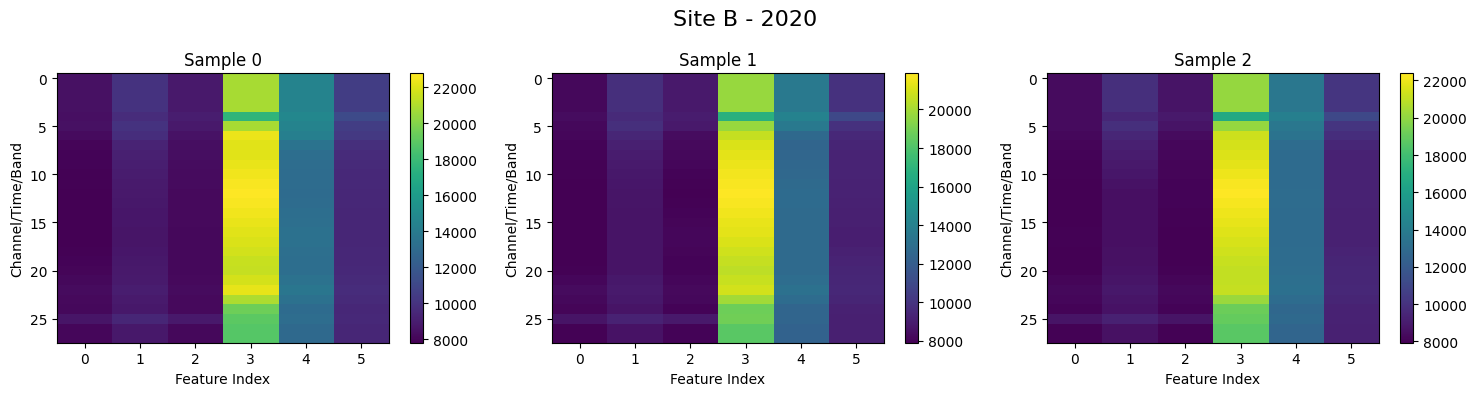

In [5]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [6]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site B - 2020 =======
Feature 0: Mean = 9293.7332, Std = 1062.0828
Feature 1: Mean = 10402.3986, Std = 1328.2403
Feature 2: Mean = 10579.1004, Std = 1999.1082
Feature 3: Mean = 18968.7555, Std = 4274.7314
Feature 4: Mean = 16319.4431, Std = 3346.2848
Feature 5: Mean = 13205.7260, Std = 3494.6972

Global Mean: 13128.1928
Global Std Dev: 4500.1056


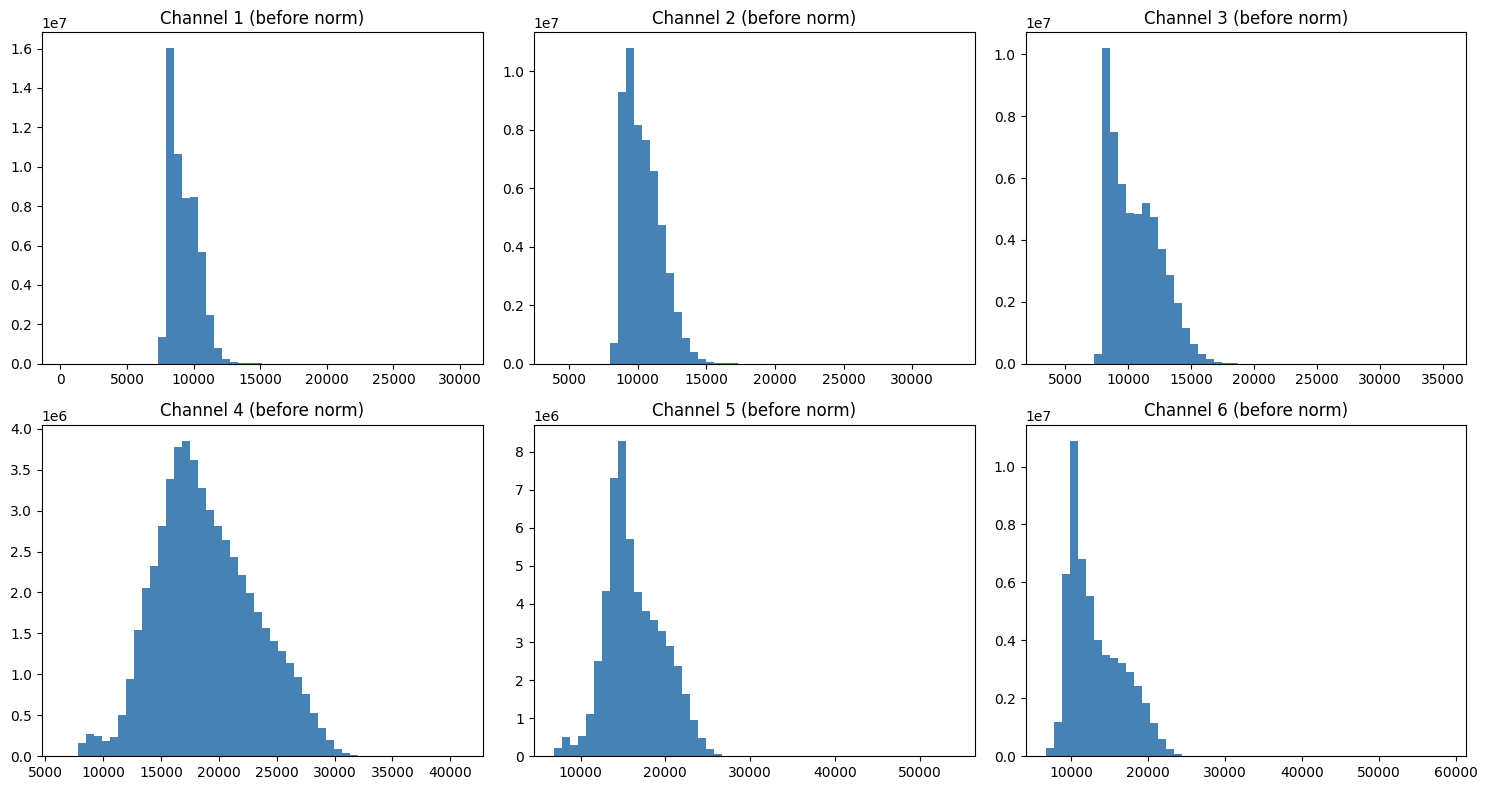

In [7]:
X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

# Before normalization
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

for i in range(6):
    axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
    axs[i].set_title(f'Channel {i+1} (before norm)')
plt.tight_layout()
plt.show()

## Preprocessing the Input

In [8]:
# Standardizing the input features across all timesteps and samples using Z-scores
# Compute per-feature mean and std across all samples and timesteps
feature_means = X.mean(axis=(0, 1))  # Shape: (6,)
feature_stds = X.std(axis=(0, 1))    # Shape: (6,)

# Reshape for broadcasting
feature_means = feature_means.reshape(1, 1, -1)  # Shape: (1, 1, 6)
feature_stds = feature_stds.reshape(1, 1, -1)    # Shape: (1, 1, 6)

# Standardize
X = ((X - feature_means) / feature_stds).astype(np.float32)

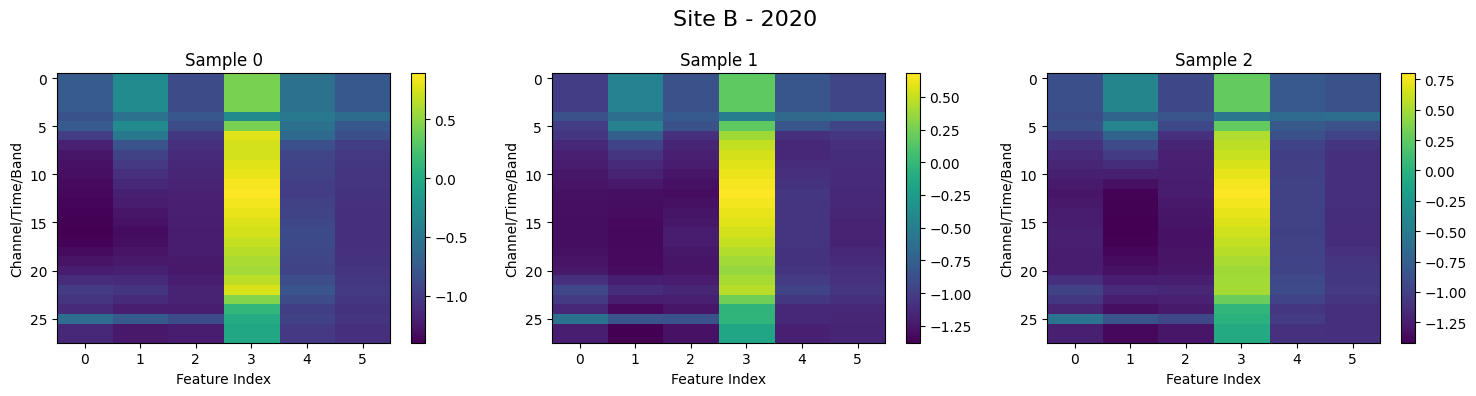

In [9]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [10]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site B - 2020 =======
Feature 0: Mean = -0.0000, Std = 0.8846
Feature 1: Mean = -0.0000, Std = 0.8950
Feature 2: Mean = 0.0000, Std = 0.8862
Feature 3: Mean = 0.0001, Std = 0.9253
Feature 4: Mean = 0.0000, Std = 0.9230
Feature 5: Mean = 0.0000, Std = 0.8994

Global Mean: -0.0000
Global Std Dev: 1.0000


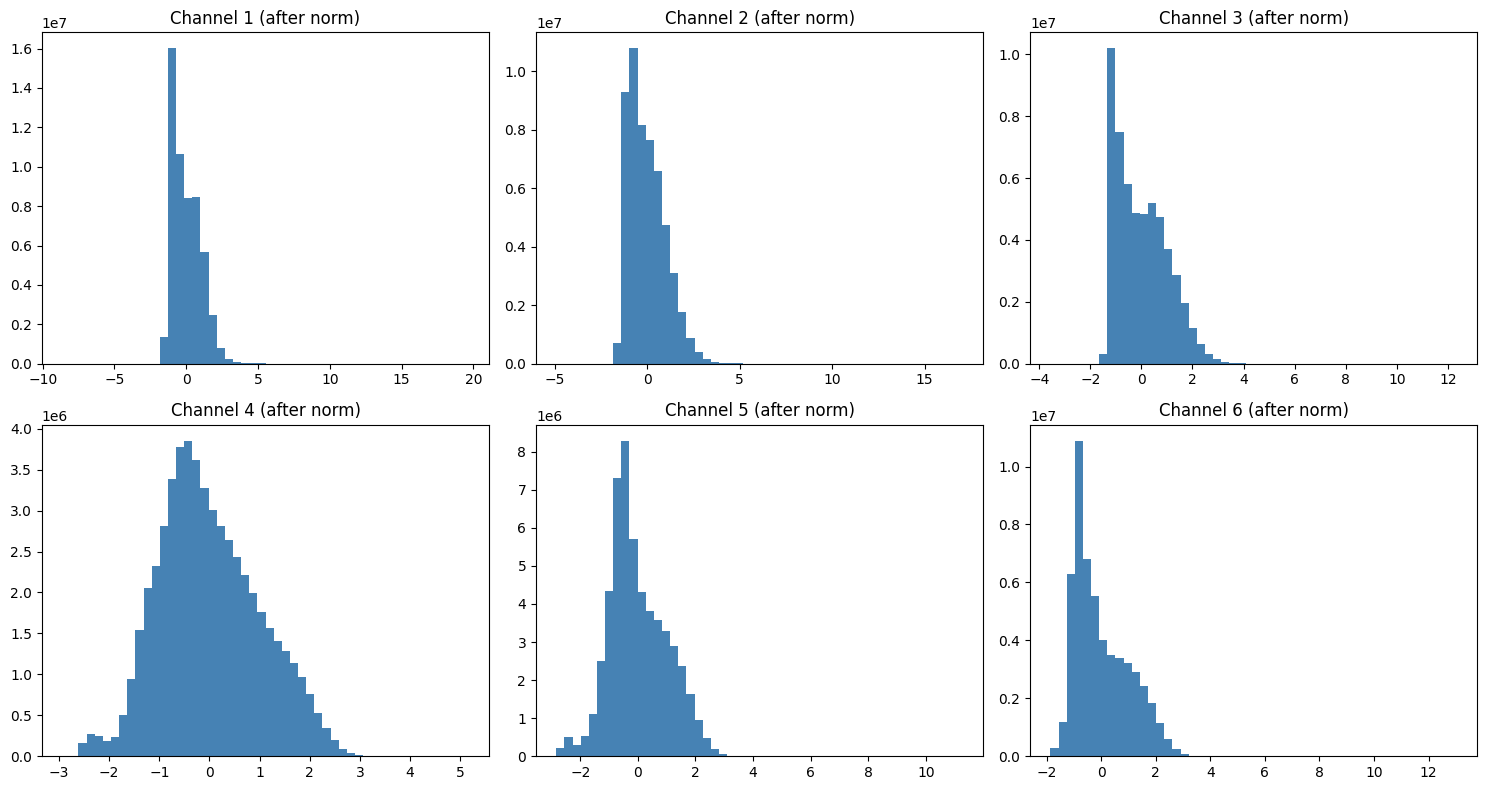

In [11]:
X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

# After normalization
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

for i in range(6):
    axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
    axs[i].set_title(f'Channel {i+1} (after norm)')
plt.tight_layout()
plt.show()

## Label Distribution



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


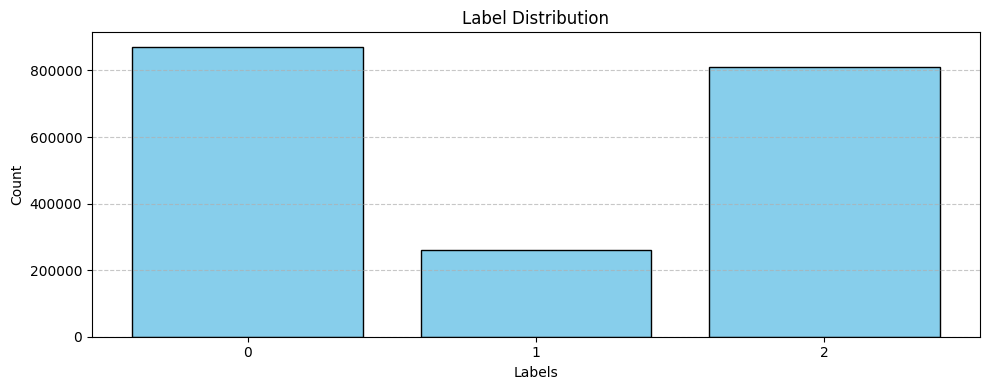

In [12]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution ======')
unique_labels, counts = np.unique(y, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Data Splits

In [13]:
# Taking only 25% percent of the data
X_subset, X_test, y_subset, y_test = train_test_split(X, y, test_size=0.75, stratify=y, random_state=42)
print('Subset Data:', X_subset.shape, y_subset.shape)
print('Test Data:', X_test.shape, y_test.shape)

Subset Data: (485929, 28, 6) (485929,)
Test Data: (1457787, 28, 6) (1457787,)


In [14]:
# Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(X_subset, y_subset, test_size=0.2, stratify=y_subset, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(388743, 28, 6) (388743,)
(97186, 28, 6) (97186,)


In [15]:
# Checking if the training data is normalized correctly
print(f'\n\n======= Training data =======')
feature_means = X_train.mean(axis=(0, 1))  # average over samples and features
feature_stds = X_train.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X_train.mean()
std = X_train.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= Training data =======
Feature 0: Mean = 0.0013, Std = 0.9957
Feature 1: Mean = 0.0013, Std = 0.9936
Feature 2: Mean = 0.0009, Std = 0.9921
Feature 3: Mean = 0.0006, Std = 0.9914
Feature 4: Mean = 0.0005, Std = 0.9904
Feature 5: Mean = 0.0004, Std = 0.9946

Global Mean: 0.0008
Global Std Dev: 1.0006




====== Label Distribution - Training data ======
Label     Count     Percentage
------------------------------
0         174206    44.81%
1         52155     13.42%
2         162382    41.77%

Total samples: 388743


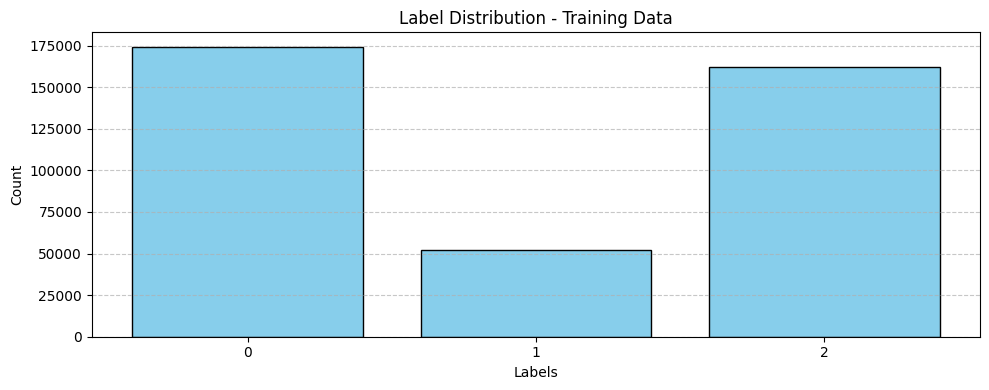

In [16]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution - Training data ======')
unique_labels, counts = np.unique(y_train, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution - Training Data")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Dataset and DataLoader

In [17]:
class Conv1dDataset(Dataset):
    def __init__(self, X, y):
        """
        X expected shape: (N, T, F)  -> convert to (N, C, L) with C=F, L=T
        Transpose to (N, F, T)
        """
        self.X = torch.tensor(X.transpose(0, 2, 1), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [18]:
val_dataset = Conv1dDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = Conv1dDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [19]:
# Blocks (Conv + FC) 
# ----------------------------
class Conv1d_BayesBlock(ModuleWrapperConv1d):
    """BBBConv1d + BN + ReLU inside a Conv1d wrapper"""
    def __init__(self, in_ch, out_ch, kernel_size, priors, device='cpu', padding=0):
        super().__init__()
        self.conv = BayesianConv1d(in_ch, out_ch, kernel_size, padding=padding, priors=priors, device=device)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

class FCBayesBlock(ModuleWrapperLinear):
    """BBBLinear (optionally add activation if you want)"""
    def __init__(self, in_f, out_f, priors, device='cpu'):
        super().__init__()
        self.dropout = nn.Dropout(p=0.3)
        self.fc = BayesianLinear(in_f, out_f, priors=priors, device=device)

In [20]:
########################################
# Bayesian CNN + FC Model
########################################
class BayesianCNN_FC(nn.Module):
    def __init__(self, in_channels=6,  num_classes=3, priors=None, device='cpu'):
        super().__init__()
        self.device = device
        self.conv1 = Conv1d_BayesBlock(in_channels, 64, 5, priors, device=device, padding=2)
        self.conv2 = Conv1d_BayesBlock(64, 128, 5, priors, device=device, padding=2)
        self.conv3 = Conv1d_BayesBlock(128, 256, 5, priors, device=device, padding=2)
        self.conv4 = Conv1d_BayesBlock(256, 512, 5, priors, device=device, padding=2)
        self.conv5 = Conv1d_BayesBlock(512, 1024, 5, priors, device=device, padding=2)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = FCBayesBlock(1024, num_classes, priors, device=device)

    def forward(self, x, sample=True, n_samples=1):
        # x: (batch, channels, length)  OR  (n_samples, batch, channels, length)
        kl_total = torch.tensor(0.0, device=x.device)

        x, kl = self.conv1(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv2(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv3(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv4(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv5(x, sample=sample, n_samples=n_samples); kl_total += kl

        # global pool (handle sample dim)
        if x.dim() == 4:  # (T, B, C, L)
            T_, B_, C_, L_ = x.shape
            x = x.reshape(T_ * B_, C_, L_)
            x = self.global_pool(x)             # (T*B, C, 1)
            x = x.squeeze(-1)                   # (T*B, C)
            x = x.reshape(T_, B_, C_)           # (T, B, C)
        elif x.dim() == 3:  # (B, C, L)
            x = self.global_pool(x)             # (B, C, 1)
            x = x.squeeze(-1)                   # (B, C)
        else:
            raise ValueError(f"Unexpected shape: {x.shape}")

        x, kl_fc = self.fc(x, sample=sample, n_samples=n_samples)
        kl_total += kl_fc

        return x, kl_total

## Evaluation Function

In [21]:
def compute_accuracy_per_sample_mean(outputs, labels):
    """
    outputs: (T, B, C) or (B, C)
    """
    if outputs.dim() == 3:
        preds = outputs.argmax(dim=2)               # (T, B)
        eq = (preds == labels.unsqueeze(0))         # (T, B)
        return eq.float().mean(dim=1).mean().item() # avg over T, then scalar
    else:
        preds = outputs.argmax(dim=1)
        return (preds == labels).float().mean().item()

In [22]:
def evaluate(model, dataloader, class_weights=None, T=T, device=DEVICE):
    sample_flag = (T > 1)
    
    all_preds = []
    all_labels = []
    total_acc = 0.0
    val_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tqdm(dataloader, desc=f"Stochastic Validation (T={T})" if sample_flag else f"Deterministic Validation (T={T})"):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            
            outputs, kl = model(x_batch, sample=sample_flag, n_samples=T)  # (T,B,C) or (B,C)

            # Loss Calculation
            nll = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
            loss = nll + KL_WEIGHT * kl
            val_loss += loss.item() * x_batch.size(0)
            

            # Accuracy before averaging predictions
            total_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)

            # Average over stochastic passes if T>1
            if sample_flag and outputs.dim() == 3:
                outputs = outputs.mean(dim=0)  # (B, C)

            # Get predictions
            probs = torch.softmax(outputs, dim=1)  # (B, C)
            preds = torch.argmax(probs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # ====== Metrics ======
    kappa = cohen_kappa_score(all_labels.numpy(), all_preds.numpy())
    per_class_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average=None)
    avg_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")
    acc = total_acc / len(dataloader.dataset)
    val_loss /= len(dataloader.dataset)
    cm = confusion_matrix(all_labels, all_preds)

    return val_loss, acc, kappa, per_class_f1, avg_f1, cm

## Acquisition Function

In [23]:
# ============= Predictive Entropy ============= 
def predictive_entropy_sampling(X, model, k, device, unlabeled_pool, T=T):
    model.eval()
    indices = list(unlabeled_pool)
    X_pool = X[indices]

    all_outputs = []
    with torch.no_grad():
        for _ in tqdm(range(T), desc="MC Dropout Simulations (PE)"):
            batch_outputs = []
            for i in range(0, len(X_pool), BATCH_SIZE):
                batch = X_pool[i:i+BATCH_SIZE]
                x_tensor = torch.tensor(batch).float().permute(0, 2, 1).to(device)

                out, _ = model(x_tensor, sample=True)   # (B, C)
                batch_outputs.append(out)               # collect (B, C)

            # stack batches back together → (N, C)
            batch_outputs = torch.cat(batch_outputs, dim=0)
            all_outputs.append(batch_outputs.unsqueeze(0))  # (1, N, C)

    # stack across T → (T, N, C)
    outputs = torch.cat(all_outputs, dim=0)

    # softmax to get probs
    probs = F.softmax(outputs, dim=-1)  # (T, N, C)

    # predictive entropy
    avg_probs = probs.mean(dim=0)  # (N, C)
    entropy = -torch.sum(avg_probs * torch.log(avg_probs + 1e-8), dim=1)  # (N,)

    topk = torch.topk(entropy, k=k).indices
    return [indices[i.item()] for i in topk]


# ============= BALD (Bayesian AL by Disagreement) ============= 
def bald_sampling(X, model, k, device, unlabeled_pool, T=20):
    model.eval()
    indices = list(unlabeled_pool)
    X_pool = X[indices]

    all_outputs = []
    with torch.no_grad():
        for _ in tqdm(range(T), desc="MC Dropout Simulations (BALD)"):
            batch_outputs = []
            for i in range(0, len(X_pool), BATCH_SIZE):
                batch = X_pool[i:i+BATCH_SIZE]
                x_tensor = torch.tensor(batch).float().permute(0, 2, 1).to(device)

                out, _ = model(x_tensor, sample=True)  # (B, C)
                batch_outputs.append(out)

            batch_outputs = torch.cat(batch_outputs, dim=0)  # (N, C)
            all_outputs.append(batch_outputs.unsqueeze(0))   # (1, N, C)

    outputs = torch.cat(all_outputs, dim=0)   # (T, N, C)
    probs = F.softmax(outputs, dim=-1)        # (T, N, C)

    avg_probs = probs.mean(dim=0)             # (N, C)

    # Predictive entropy
    H = -torch.sum(avg_probs * torch.log(avg_probs + 1e-8), dim=1)  # (N,)

    # Expected entropy
    E_H = -torch.sum(probs * torch.log(probs + 1e-8), dim=2).mean(dim=0)  # (N,)

    bald_score = H - E_H
    topk = torch.topk(bald_score, k=k).indices
    return [indices[i.item()] for i in topk]


# ============= Variation Ratios ============= 
def variation_ratio_sampling(X, model, k, device, unlabeled_pool, T=20):
    model.eval()
    indices = list(unlabeled_pool)
    X_pool = X[indices]

    all_preds = []
    with torch.no_grad():
        for _ in tqdm(range(T), desc="MC Dropout Simulations (VR)"):
            batch_preds = []
            for i in range(0, len(X_pool), BATCH_SIZE):
                batch = X_pool[i:i+BATCH_SIZE]
                x_tensor = torch.tensor(batch).float().permute(0, 2, 1).to(device)

                out, _ = model(x_tensor, sample=True)     # (B, C)
                pred = torch.argmax(out, dim=-1)          # (B,)
                batch_preds.append(pred)

            batch_preds = torch.cat(batch_preds, dim=0)  # (N,)
            all_preds.append(batch_preds.unsqueeze(0))   # (1, N)

    preds = torch.cat(all_preds, dim=0)  # (T, N)

    mode_preds = torch.mode(preds, dim=0).values        # (N,)
    agreement = (preds == mode_preds.unsqueeze(0)).sum(dim=0)  # (N,)
    variation_ratio = 1 - agreement.float() / T         # (N,)

    topk = torch.topk(variation_ratio, k=k).indices
    return [indices[i.item()] for i in topk]


# ============= BvSB (Best vs Second Best) ============= 
def bvsb_sampling(X, model, k, device, unlabeled_pool, T=20):
    model.eval()
    indices = list(unlabeled_pool)
    X_pool = X[indices]

    all_outputs = []
    with torch.no_grad():
        for _ in tqdm(range(T), desc="MC Dropout Simulations (BvSB)"):
            batch_outputs = []
            for i in range(0, len(X_pool), BATCH_SIZE):
                batch = X_pool[i:i+BATCH_SIZE]
                x_tensor = torch.tensor(batch).float().permute(0, 2, 1).to(device)

                out, _ = model(x_tensor, sample=True)  # (B, C)
                batch_outputs.append(out)

            batch_outputs = torch.cat(batch_outputs, dim=0)  # (N, C)
            all_outputs.append(batch_outputs.unsqueeze(0))   # (1, N, C)

    outputs = torch.cat(all_outputs, dim=0)  # (T, N, C)
    probs = F.softmax(outputs, dim=-1)       # (T, N, C)

    avg_probs = probs.mean(dim=0)            # (N, C)
    sorted_probs, _ = torch.sort(avg_probs, dim=1)  # (N, C)
    margins = sorted_probs[:, -1] - sorted_probs[:, -2]  # (N,)

    topk = torch.topk(-margins, k=k).indices  # smaller margin = more uncertainty
    return [indices[i.item()] for i in topk]

In [24]:
# Only 2 strategies this time
sampling_strategies = {
    "predictive_entropy": predictive_entropy_sampling,
    "bald": bald_sampling
    # "variation_ratio": variation_ratio_sampling,
    # "bvsb": bvsb_sampling
}

# Create separate pools and histories for each strategy
strategy_pools = {}
strategy_histories = {}

for name in sampling_strategies:
    strategy_pools[name] = {
        "labeled": set(),
        "unlabeled": set(range(len(X_train)))
    }
    
    strategy_histories[name] = {
        "rounds": [],
        "num_labeled": [],
        "train_accuracy": [],
        "train_loss": [],
        "val_accuracy": [],
        "val_loss": [],
        "avg_f1": [],
        "per_class_f1": [],
        "kappa": []
    }

## Training Loop

In [25]:
def ELBO_loss_nll_from_logits(outputs, y_batch, class_weights=None):
    """
    outputs: (T, B, C) or (B, C)
    y_batch: (B,)
    """
    if outputs.dim() == 3:
        T, B, C = outputs.shape
        outputs_flat = outputs.reshape(T * B, C)
        labels_rep = y_batch.unsqueeze(0).expand(T, B).reshape(T * B)
        return F.cross_entropy(outputs_flat, labels_rep,
                               weight=class_weights, reduction='mean')
    else:
        return F.cross_entropy(outputs, y_batch,
                               weight=class_weights, reduction='mean')

In [26]:
# ===== Training Loop =====
def train(model, train_dataset, train_loader, optimizer, class_weights=None, KL_WEIGHT=1e-8, EPOCHS=15, T=15):
    train_losses, train_accs = [], []

    for epoch in range(EPOCHS):
        # === TRAIN ===
        model.train()
        train_loss = 0.0
        train_acc = 0.0
    
        for x_batch, y_batch in tqdm(train_loader, desc=f'Training Epoch {epoch+1}'):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
    
            optimizer.zero_grad()
    
            # Forward pass with T stochastic samples
            outputs, kl = model(x_batch, sample=True, n_samples=T)  # (T,B,C) + scalar KL
    
            # Mean NLL across T samples
            nll_mean = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
            
            # ELBO Loss
            loss = nll_mean + KL_WEIGHT * kl
    
            # Backprop
            loss.backward()
            optimizer.step()
    
            # Stats
            train_loss += loss.item() * x_batch.size(0)
            train_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)
    
        train_loss /= len(train_dataset)
        train_acc /= len(train_dataset)

        # Save stats
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f'Loss: {nll_mean:.4f} + {KL_WEIGHT} * {kl}')
        print(f'Loss: {nll_mean:.4f} + {KL_WEIGHT * kl}')
    
        print(f"Epoch [{epoch+1}/{EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}") 

    return train_losses, train_accs

## AL Pipeline Loop

In [27]:
# Calculate total and effective samples
total_samples = AL_ROUNDS * QUERY_SIZE + INITIAL_LABELED
effective_samples = INITIAL_LABELED * AL_ROUNDS + QUERY_SIZE * (AL_ROUNDS * (AL_ROUNDS + 1)) // 2  # Sum of 1+2+...+num_rounds

# Nicely formatted print
print("=" * 50)
print(" Active Learning Configuration Summary")
print("=" * 50)
print(f"Stochastic Passes:          {T}")
print(f"Number of Rounds:           {AL_ROUNDS}")
print(f"Initial Labeled Samples:    {INITIAL_LABELED}")
print(f"Query Size per Round:       {QUERY_SIZE}")
print(f"Number of epochs:           {EPOCHS}")
print(f"Total Labeled Samples:      {total_samples}")
print(f"Effective Samples (Total):  {effective_samples}")
print("=" * 50)

 Active Learning Configuration Summary
Stochastic Passes:          10
Number of Rounds:           10
Initial Labeled Samples:    4000
Query Size per Round:       1000
Number of epochs:           20
Total Labeled Samples:      14000
Effective Samples (Total):  95000



 Running strategy: PREDICTIVE_ENTROPY 
Length of Labeled Pool: 0
Length of Unlabeled Pool: 388743
Length of Labeled Pool: 4000
Length of Unlabeled Pool: 384743
Class weights: tensor([0.7550, 1.2500, 0.7974], device='cuda:0')

-> Training on 4000 initially labeled samples 


Training Epoch 1: 100%|██████████| 63/63 [00:02<00:00, 25.38it/s]


Loss: 0.3519 + 1e-08 * 2859660.5
Loss: 0.3519 + 0.028596604242920876
Epoch [1/20] Train Loss: 0.8850, Train Acc: 0.7085


Training Epoch 2: 100%|██████████| 63/63 [00:01<00:00, 42.70it/s]


Loss: 0.4791 + 1e-08 * 2849900.0
Loss: 0.4791 + 0.028498999774456024
Epoch [2/20] Train Loss: 0.5172, Train Acc: 0.8160


Training Epoch 3: 100%|██████████| 63/63 [00:01<00:00, 42.48it/s]


Loss: 0.4408 + 1e-08 * 2839611.0
Loss: 0.4408 + 0.028396109119057655
Epoch [3/20] Train Loss: 0.4496, Train Acc: 0.8410


Training Epoch 4: 100%|██████████| 63/63 [00:01<00:00, 42.52it/s]


Loss: 0.4285 + 1e-08 * 2828472.75
Loss: 0.4285 + 0.028284726664423943
Epoch [4/20] Train Loss: 0.4072, Train Acc: 0.8468


Training Epoch 5: 100%|██████████| 63/63 [00:01<00:00, 42.68it/s]


Loss: 0.3024 + 1e-08 * 2817025.5
Loss: 0.3024 + 0.028170254081487656
Epoch [5/20] Train Loss: 0.3736, Train Acc: 0.8650


Training Epoch 6: 100%|██████████| 63/63 [00:01<00:00, 42.41it/s]


Loss: 0.2075 + 1e-08 * 2805014.5
Loss: 0.2075 + 0.028050145134329796
Epoch [6/20] Train Loss: 0.3689, Train Acc: 0.8708


Training Epoch 7: 100%|██████████| 63/63 [00:01<00:00, 41.51it/s]


Loss: 0.1268 + 1e-08 * 2792475.5
Loss: 0.1268 + 0.027924755588173866
Epoch [7/20] Train Loss: 0.3521, Train Acc: 0.8735


Training Epoch 8: 100%|██████████| 63/63 [00:01<00:00, 42.16it/s]


Loss: 0.4162 + 1e-08 * 2779585.0
Loss: 0.4162 + 0.02779584936797619
Epoch [8/20] Train Loss: 0.3552, Train Acc: 0.8700


Training Epoch 9: 100%|██████████| 63/63 [00:01<00:00, 42.20it/s]


Loss: 0.2471 + 1e-08 * 2767578.75
Loss: 0.2471 + 0.02767578698694706
Epoch [9/20] Train Loss: 0.3362, Train Acc: 0.8762


Training Epoch 10: 100%|██████████| 63/63 [00:01<00:00, 41.94it/s]


Loss: 0.1666 + 1e-08 * 2754247.0
Loss: 0.1666 + 0.027542470023036003
Epoch [10/20] Train Loss: 0.3453, Train Acc: 0.8800


Training Epoch 11: 100%|██████████| 63/63 [00:01<00:00, 42.50it/s]


Loss: 0.8524 + 1e-08 * 2741700.25
Loss: 0.8524 + 0.027417002245783806
Epoch [11/20] Train Loss: 0.3355, Train Acc: 0.8768


Training Epoch 12: 100%|██████████| 63/63 [00:01<00:00, 42.05it/s]


Loss: 0.2950 + 1e-08 * 2730825.75
Loss: 0.2950 + 0.027308257296681404
Epoch [12/20] Train Loss: 0.3198, Train Acc: 0.8838


Training Epoch 13: 100%|██████████| 63/63 [00:01<00:00, 42.01it/s]


Loss: 0.2650 + 1e-08 * 2718173.5
Loss: 0.2650 + 0.027181735262274742
Epoch [13/20] Train Loss: 0.3079, Train Acc: 0.8862


Training Epoch 14: 100%|██████████| 63/63 [00:01<00:00, 42.11it/s]


Loss: 0.4623 + 1e-08 * 2706742.0
Loss: 0.4623 + 0.02706741914153099
Epoch [14/20] Train Loss: 0.3155, Train Acc: 0.8892


Training Epoch 15: 100%|██████████| 63/63 [00:01<00:00, 42.53it/s]


Loss: 0.3777 + 1e-08 * 2694313.75
Loss: 0.3777 + 0.026943137869238853
Epoch [15/20] Train Loss: 0.3091, Train Acc: 0.8908


Training Epoch 16: 100%|██████████| 63/63 [00:01<00:00, 42.22it/s]


Loss: 0.3438 + 1e-08 * 2684288.25
Loss: 0.3438 + 0.026842882856726646
Epoch [16/20] Train Loss: 0.3065, Train Acc: 0.8930


Training Epoch 17: 100%|██████████| 63/63 [00:01<00:00, 42.34it/s]


Loss: 0.2048 + 1e-08 * 2673173.25
Loss: 0.2048 + 0.026731733232736588
Epoch [17/20] Train Loss: 0.3015, Train Acc: 0.8890


Training Epoch 18: 100%|██████████| 63/63 [00:01<00:00, 42.12it/s]


Loss: 0.2684 + 1e-08 * 2662480.25
Loss: 0.2684 + 0.026624802500009537
Epoch [18/20] Train Loss: 0.2922, Train Acc: 0.8978


Training Epoch 19: 100%|██████████| 63/63 [00:01<00:00, 42.32it/s]


Loss: 0.4268 + 1e-08 * 2651649.75
Loss: 0.4268 + 0.026516497135162354
Epoch [19/20] Train Loss: 0.2810, Train Acc: 0.9018


Training Epoch 20: 100%|██████████| 63/63 [00:01<00:00, 42.14it/s]


Loss: 0.1690 + 1e-08 * 2642488.25
Loss: 0.1690 + 0.02642488293349743
Epoch [20/20] Train Loss: 0.2931, Train Acc: 0.8905


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 134.98it/s]


Per-class F1 scores: [0.88719817 0.89344323 0.89064618]
Validation Accuracy: 88.95%
Validation Loss: 0.3125
Average F1 Score: 0.8904
Kappa: 0.8186

--- Round 1 [predictive_entropy] ---


MC Dropout Simulations (PE): 100%|██████████| 10/10 [06:35<00:00, 39.51s/it]


Length of Labeled Pool: 5000
Length of Unlabeled Pool: 383743


Training Epoch 1: 100%|██████████| 79/79 [00:01<00:00, 41.02it/s]


Loss: 0.7289 + 1e-08 * 2624321.25
Loss: 0.7289 + 0.026243211701512337
Epoch [1/20] Train Loss: 0.4715, Train Acc: 0.8006


Training Epoch 2: 100%|██████████| 79/79 [00:01<00:00, 41.59it/s]


Loss: 0.5726 + 1e-08 * 2612463.25
Loss: 0.5726 + 0.026124631986021996
Epoch [2/20] Train Loss: 0.4568, Train Acc: 0.8058


Training Epoch 3: 100%|██████████| 79/79 [00:01<00:00, 42.15it/s]


Loss: 0.3378 + 1e-08 * 2600254.0
Loss: 0.3378 + 0.026002539321780205
Epoch [3/20] Train Loss: 0.4495, Train Acc: 0.8118


Training Epoch 4: 100%|██████████| 79/79 [00:01<00:00, 41.89it/s]


Loss: 0.5619 + 1e-08 * 2588335.5
Loss: 0.5619 + 0.025883354246616364
Epoch [4/20] Train Loss: 0.4476, Train Acc: 0.8142


Training Epoch 5: 100%|██████████| 79/79 [00:01<00:00, 42.23it/s]


Loss: 0.8515 + 1e-08 * 2579294.25
Loss: 0.8515 + 0.025792941451072693
Epoch [5/20] Train Loss: 0.4482, Train Acc: 0.8110


Training Epoch 6: 100%|██████████| 79/79 [00:01<00:00, 42.20it/s]


Loss: 0.2449 + 1e-08 * 2569127.5
Loss: 0.2449 + 0.02569127455353737
Epoch [6/20] Train Loss: 0.4421, Train Acc: 0.8162


Training Epoch 7: 100%|██████████| 79/79 [00:01<00:00, 41.61it/s]


Loss: 0.5855 + 1e-08 * 2556695.0
Loss: 0.5855 + 0.0255669504404068
Epoch [7/20] Train Loss: 0.4237, Train Acc: 0.8258


Training Epoch 8: 100%|██████████| 79/79 [00:01<00:00, 41.79it/s]


Loss: 0.5035 + 1e-08 * 2545315.0
Loss: 0.5035 + 0.025453150272369385
Epoch [8/20] Train Loss: 0.4255, Train Acc: 0.8244


Training Epoch 9: 100%|██████████| 79/79 [00:01<00:00, 41.76it/s]


Loss: 0.5378 + 1e-08 * 2536569.5
Loss: 0.5378 + 0.025365695357322693
Epoch [9/20] Train Loss: 0.4161, Train Acc: 0.8322


Training Epoch 10: 100%|██████████| 79/79 [00:01<00:00, 42.07it/s]


Loss: 0.8858 + 1e-08 * 2526512.0
Loss: 0.8858 + 0.025265119969844818
Epoch [10/20] Train Loss: 0.4093, Train Acc: 0.8348


Training Epoch 11: 100%|██████████| 79/79 [00:01<00:00, 41.92it/s]


Loss: 0.3133 + 1e-08 * 2520624.0
Loss: 0.3133 + 0.02520623989403248
Epoch [11/20] Train Loss: 0.4211, Train Acc: 0.8284


Training Epoch 12: 100%|██████████| 79/79 [00:01<00:00, 41.79it/s]


Loss: 0.2608 + 1e-08 * 2510007.25
Loss: 0.2608 + 0.025100072845816612
Epoch [12/20] Train Loss: 0.4023, Train Acc: 0.8372


Training Epoch 13: 100%|██████████| 79/79 [00:01<00:00, 41.62it/s]


Loss: 0.5445 + 1e-08 * 2500948.75
Loss: 0.5445 + 0.025009486824274063
Epoch [13/20] Train Loss: 0.4037, Train Acc: 0.8308


Training Epoch 14: 100%|██████████| 79/79 [00:01<00:00, 42.08it/s]


Loss: 0.2936 + 1e-08 * 2492868.25
Loss: 0.2936 + 0.024928681552410126
Epoch [14/20] Train Loss: 0.4080, Train Acc: 0.8344


Training Epoch 15: 100%|██████████| 79/79 [00:01<00:00, 42.24it/s]


Loss: 0.6331 + 1e-08 * 2485140.5
Loss: 0.6331 + 0.024851404130458832
Epoch [15/20] Train Loss: 0.4025, Train Acc: 0.8378


Training Epoch 16: 100%|██████████| 79/79 [00:01<00:00, 42.09it/s]


Loss: 1.3623 + 1e-08 * 2476729.0
Loss: 1.3623 + 0.02476728893816471
Epoch [16/20] Train Loss: 0.3935, Train Acc: 0.8376


Training Epoch 17: 100%|██████████| 79/79 [00:01<00:00, 41.70it/s]


Loss: 0.4103 + 1e-08 * 2469670.75
Loss: 0.4103 + 0.024696707725524902
Epoch [17/20] Train Loss: 0.3830, Train Acc: 0.8452


Training Epoch 18: 100%|██████████| 79/79 [00:01<00:00, 41.88it/s]


Loss: 0.3736 + 1e-08 * 2460513.5
Loss: 0.3736 + 0.02460513450205326
Epoch [18/20] Train Loss: 0.3819, Train Acc: 0.8496


Training Epoch 19: 100%|██████████| 79/79 [00:01<00:00, 41.89it/s]


Loss: 0.3365 + 1e-08 * 2451907.0
Loss: 0.3365 + 0.024519069120287895
Epoch [19/20] Train Loss: 0.3863, Train Acc: 0.8436


Training Epoch 20: 100%|██████████| 79/79 [00:01<00:00, 42.17it/s]


Loss: 0.7838 + 1e-08 * 2446134.25
Loss: 0.7838 + 0.02446134202182293
Epoch [20/20] Train Loss: 0.3842, Train Acc: 0.8448


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 135.21it/s]


Per-class F1 scores: [0.89585802 0.90582823 0.89528555]
Validation Accuracy: 89.70%
Validation Loss: 0.3074
Average F1 Score: 0.8990
Kappa: 0.8303

--- Round 2 [predictive_entropy] ---


MC Dropout Simulations (PE): 100%|██████████| 10/10 [06:34<00:00, 39.42s/it]


Length of Labeled Pool: 6000
Length of Unlabeled Pool: 382743


Training Epoch 1: 100%|██████████| 94/94 [00:02<00:00, 41.02it/s]


Loss: 0.5267 + 1e-08 * 2432807.5
Loss: 0.5267 + 0.024328075349330902
Epoch [1/20] Train Loss: 0.5255, Train Acc: 0.7713


Training Epoch 2: 100%|██████████| 94/94 [00:02<00:00, 42.04it/s]


Loss: 0.3605 + 1e-08 * 2421494.0
Loss: 0.3605 + 0.024214940145611763
Epoch [2/20] Train Loss: 0.5126, Train Acc: 0.7803


Training Epoch 3: 100%|██████████| 94/94 [00:02<00:00, 41.98it/s]


Loss: 0.3062 + 1e-08 * 2411737.5
Loss: 0.3062 + 0.024117374792695045
Epoch [3/20] Train Loss: 0.4933, Train Acc: 0.7902


Training Epoch 4: 100%|██████████| 94/94 [00:02<00:00, 41.71it/s]


Loss: 0.3219 + 1e-08 * 2402134.5
Loss: 0.3219 + 0.024021344259381294
Epoch [4/20] Train Loss: 0.5026, Train Acc: 0.7803


Training Epoch 5: 100%|██████████| 94/94 [00:02<00:00, 41.86it/s]


Loss: 0.6263 + 1e-08 * 2391697.25
Loss: 0.6263 + 0.023916972801089287
Epoch [5/20] Train Loss: 0.4973, Train Acc: 0.7880


Training Epoch 6: 100%|██████████| 94/94 [00:02<00:00, 42.16it/s]


Loss: 0.3675 + 1e-08 * 2384333.25
Loss: 0.3675 + 0.02384333312511444
Epoch [6/20] Train Loss: 0.4920, Train Acc: 0.7880


Training Epoch 7: 100%|██████████| 94/94 [00:02<00:00, 42.03it/s]


Loss: 0.3266 + 1e-08 * 2375506.75
Loss: 0.3266 + 0.023755067959427834
Epoch [7/20] Train Loss: 0.4907, Train Acc: 0.7910


Training Epoch 8: 100%|██████████| 94/94 [00:02<00:00, 41.97it/s]


Loss: 0.3980 + 1e-08 * 2367266.75
Loss: 0.3980 + 0.023672668263316154
Epoch [8/20] Train Loss: 0.4770, Train Acc: 0.7962


Training Epoch 9: 100%|██████████| 94/94 [00:02<00:00, 41.72it/s]


Loss: 0.5481 + 1e-08 * 2360031.5
Loss: 0.5481 + 0.023600315675139427
Epoch [9/20] Train Loss: 0.4749, Train Acc: 0.8065


Training Epoch 10: 100%|██████████| 94/94 [00:02<00:00, 42.10it/s]


Loss: 0.6333 + 1e-08 * 2352097.75
Loss: 0.6333 + 0.023520978167653084
Epoch [10/20] Train Loss: 0.4779, Train Acc: 0.8008


Training Epoch 11: 100%|██████████| 94/94 [00:02<00:00, 42.15it/s]


Loss: 0.4177 + 1e-08 * 2344894.25
Loss: 0.4177 + 0.023448942229151726
Epoch [11/20] Train Loss: 0.4804, Train Acc: 0.7928


Training Epoch 12: 100%|██████████| 94/94 [00:02<00:00, 42.01it/s]


Loss: 0.4302 + 1e-08 * 2338260.25
Loss: 0.4302 + 0.023382602259516716
Epoch [12/20] Train Loss: 0.4733, Train Acc: 0.8017


Training Epoch 13: 100%|██████████| 94/94 [00:02<00:00, 41.92it/s]


Loss: 0.5247 + 1e-08 * 2330419.0
Loss: 0.5247 + 0.02330419048666954
Epoch [13/20] Train Loss: 0.4677, Train Acc: 0.8008


Training Epoch 14: 100%|██████████| 94/94 [00:02<00:00, 41.71it/s]


Loss: 0.4306 + 1e-08 * 2326399.0
Loss: 0.4306 + 0.02326398901641369
Epoch [14/20] Train Loss: 0.4680, Train Acc: 0.8045


Training Epoch 15: 100%|██████████| 94/94 [00:02<00:00, 41.53it/s]


Loss: 0.4050 + 1e-08 * 2319263.25
Loss: 0.4050 + 0.0231926329433918
Epoch [15/20] Train Loss: 0.4561, Train Acc: 0.8037


Training Epoch 16: 100%|██████████| 94/94 [00:02<00:00, 41.93it/s]


Loss: 0.3264 + 1e-08 * 2311132.5
Loss: 0.3264 + 0.02311132475733757
Epoch [16/20] Train Loss: 0.4584, Train Acc: 0.8063


Training Epoch 17: 100%|██████████| 94/94 [00:02<00:00, 41.91it/s]


Loss: 0.5034 + 1e-08 * 2305879.0
Loss: 0.5034 + 0.02305879071354866
Epoch [17/20] Train Loss: 0.4596, Train Acc: 0.8072


Training Epoch 18: 100%|██████████| 94/94 [00:02<00:00, 41.39it/s]


Loss: 0.4598 + 1e-08 * 2298150.25
Loss: 0.4598 + 0.02298150211572647
Epoch [18/20] Train Loss: 0.4556, Train Acc: 0.8045


Training Epoch 19: 100%|██████████| 94/94 [00:02<00:00, 42.02it/s]


Loss: 0.3095 + 1e-08 * 2293588.75
Loss: 0.3095 + 0.022935887798666954
Epoch [19/20] Train Loss: 0.4341, Train Acc: 0.8207


Training Epoch 20: 100%|██████████| 94/94 [00:02<00:00, 41.78it/s]


Loss: 0.3571 + 1e-08 * 2288308.0
Loss: 0.3571 + 0.022883079946041107
Epoch [20/20] Train Loss: 0.4439, Train Acc: 0.8168


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 134.76it/s]


Per-class F1 scores: [0.89508127 0.90257784 0.88695964]
Validation Accuracy: 89.29%
Validation Loss: 0.3235
Average F1 Score: 0.8949
Kappa: 0.8239

--- Round 3 [predictive_entropy] ---


MC Dropout Simulations (PE): 100%|██████████| 10/10 [06:32<00:00, 39.29s/it]


Length of Labeled Pool: 7000
Length of Unlabeled Pool: 381743


Training Epoch 1: 100%|██████████| 110/110 [00:02<00:00, 42.43it/s]


Loss: 0.5910 + 1e-08 * 2276470.25
Loss: 0.5910 + 0.022764703258872032
Epoch [1/20] Train Loss: 0.5463, Train Acc: 0.7599


Training Epoch 2: 100%|██████████| 110/110 [00:02<00:00, 42.73it/s]


Loss: 0.6491 + 1e-08 * 2268317.5
Loss: 0.6491 + 0.022683175280690193
Epoch [2/20] Train Loss: 0.5367, Train Acc: 0.7701


Training Epoch 3: 100%|██████████| 110/110 [00:02<00:00, 42.76it/s]


Loss: 0.4621 + 1e-08 * 2261154.25
Loss: 0.4621 + 0.02261154167354107
Epoch [3/20] Train Loss: 0.5377, Train Acc: 0.7667


Training Epoch 4: 100%|██████████| 110/110 [00:02<00:00, 42.75it/s]


Loss: 0.3331 + 1e-08 * 2253686.25
Loss: 0.3331 + 0.022536862641572952
Epoch [4/20] Train Loss: 0.5265, Train Acc: 0.7747


Training Epoch 5: 100%|██████████| 110/110 [00:02<00:00, 42.20it/s]


Loss: 0.4284 + 1e-08 * 2245305.5
Loss: 0.4284 + 0.022453054785728455
Epoch [5/20] Train Loss: 0.5242, Train Acc: 0.7783


Training Epoch 6: 100%|██████████| 110/110 [00:02<00:00, 42.96it/s]


Loss: 0.5562 + 1e-08 * 2239398.0
Loss: 0.5562 + 0.022393979132175446
Epoch [6/20] Train Loss: 0.5237, Train Acc: 0.7793


Training Epoch 7: 100%|██████████| 110/110 [00:02<00:00, 42.69it/s]


Loss: 0.3843 + 1e-08 * 2232429.5
Loss: 0.3843 + 0.022324295714497566
Epoch [7/20] Train Loss: 0.5208, Train Acc: 0.7743


Training Epoch 8: 100%|██████████| 110/110 [00:02<00:00, 42.55it/s]


Loss: 0.6405 + 1e-08 * 2226138.0
Loss: 0.6405 + 0.022261379286646843
Epoch [8/20] Train Loss: 0.5234, Train Acc: 0.7706


Training Epoch 9: 100%|██████████| 110/110 [00:02<00:00, 42.38it/s]


Loss: 0.5669 + 1e-08 * 2220380.25
Loss: 0.5669 + 0.022203803062438965
Epoch [9/20] Train Loss: 0.5151, Train Acc: 0.7733


Training Epoch 10: 100%|██████████| 110/110 [00:02<00:00, 42.53it/s]


Loss: 0.3584 + 1e-08 * 2215263.25
Loss: 0.3584 + 0.022152632474899292
Epoch [10/20] Train Loss: 0.5039, Train Acc: 0.7864


Training Epoch 11: 100%|██████████| 110/110 [00:02<00:00, 42.78it/s]


Loss: 0.5224 + 1e-08 * 2210026.25
Loss: 0.5224 + 0.022100262343883514
Epoch [11/20] Train Loss: 0.5003, Train Acc: 0.7863


Training Epoch 12: 100%|██████████| 110/110 [00:02<00:00, 42.44it/s]


Loss: 0.3598 + 1e-08 * 2206279.25
Loss: 0.3598 + 0.022062791511416435
Epoch [12/20] Train Loss: 0.5128, Train Acc: 0.7841


Training Epoch 13: 100%|██████████| 110/110 [00:02<00:00, 42.43it/s]


Loss: 0.2883 + 1e-08 * 2199930.75
Loss: 0.2883 + 0.021999306976795197
Epoch [13/20] Train Loss: 0.4964, Train Acc: 0.7867


Training Epoch 14: 100%|██████████| 110/110 [00:02<00:00, 42.88it/s]


Loss: 0.5381 + 1e-08 * 2194767.5
Loss: 0.5381 + 0.021947674453258514
Epoch [14/20] Train Loss: 0.4953, Train Acc: 0.7917


Training Epoch 15: 100%|██████████| 110/110 [00:02<00:00, 42.31it/s]


Loss: 0.3982 + 1e-08 * 2189054.25
Loss: 0.3982 + 0.021890541538596153
Epoch [15/20] Train Loss: 0.4958, Train Acc: 0.7890


Training Epoch 16: 100%|██████████| 110/110 [00:02<00:00, 42.40it/s]


Loss: 0.5084 + 1e-08 * 2184496.75
Loss: 0.5084 + 0.02184496819972992
Epoch [16/20] Train Loss: 0.5009, Train Acc: 0.7881


Training Epoch 17: 100%|██████████| 110/110 [00:02<00:00, 42.42it/s]


Loss: 0.5311 + 1e-08 * 2179032.75
Loss: 0.5311 + 0.02179032750427723
Epoch [17/20] Train Loss: 0.4916, Train Acc: 0.7954


Training Epoch 18: 100%|██████████| 110/110 [00:02<00:00, 42.61it/s]


Loss: 0.3726 + 1e-08 * 2174961.25
Loss: 0.3726 + 0.02174961194396019
Epoch [18/20] Train Loss: 0.4916, Train Acc: 0.7964


Training Epoch 19: 100%|██████████| 110/110 [00:02<00:00, 42.76it/s]


Loss: 0.3807 + 1e-08 * 2171035.25
Loss: 0.3807 + 0.02171035297214985
Epoch [19/20] Train Loss: 0.4842, Train Acc: 0.7964


Training Epoch 20: 100%|██████████| 110/110 [00:02<00:00, 42.04it/s]


Loss: 0.3281 + 1e-08 * 2166612.25
Loss: 0.3281 + 0.02166612260043621
Epoch [20/20] Train Loss: 0.4760, Train Acc: 0.7981


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 135.44it/s]


Per-class F1 scores: [0.89655793 0.90693727 0.88976099]
Validation Accuracy: 89.52%
Validation Loss: 0.3162
Average F1 Score: 0.8978
Kappa: 0.8275

--- Round 4 [predictive_entropy] ---


MC Dropout Simulations (PE): 100%|██████████| 10/10 [06:30<00:00, 39.01s/it]


Length of Labeled Pool: 8000
Length of Unlabeled Pool: 380743


Training Epoch 1: 100%|██████████| 125/125 [00:02<00:00, 42.41it/s]


Loss: 0.6488 + 1e-08 * 2156801.5
Loss: 0.6488 + 0.021568015217781067
Epoch [1/20] Train Loss: 0.5868, Train Acc: 0.7429


Training Epoch 2: 100%|██████████| 125/125 [00:02<00:00, 42.35it/s]


Loss: 0.5968 + 1e-08 * 2149341.0
Loss: 0.5968 + 0.02149341069161892
Epoch [2/20] Train Loss: 0.5738, Train Acc: 0.7486


Training Epoch 3: 100%|██████████| 125/125 [00:02<00:00, 42.06it/s]


Loss: 0.5241 + 1e-08 * 2143284.0
Loss: 0.5241 + 0.021432839334011078
Epoch [3/20] Train Loss: 0.5672, Train Acc: 0.7546


Training Epoch 4: 100%|██████████| 125/125 [00:02<00:00, 42.20it/s]


Loss: 0.6794 + 1e-08 * 2136486.75
Loss: 0.6794 + 0.021364867687225342
Epoch [4/20] Train Loss: 0.5548, Train Acc: 0.7566


Training Epoch 5: 100%|██████████| 125/125 [00:02<00:00, 42.57it/s]


Loss: 0.5781 + 1e-08 * 2132435.25
Loss: 0.5781 + 0.02132435329258442
Epoch [5/20] Train Loss: 0.5645, Train Acc: 0.7591


Training Epoch 6: 100%|██████████| 125/125 [00:02<00:00, 42.16it/s]


Loss: 0.7239 + 1e-08 * 2128221.75
Loss: 0.7239 + 0.021282216534018517
Epoch [6/20] Train Loss: 0.5516, Train Acc: 0.7631


Training Epoch 7: 100%|██████████| 125/125 [00:02<00:00, 42.21it/s]


Loss: 0.5265 + 1e-08 * 2123747.5
Loss: 0.5265 + 0.02123747579753399
Epoch [7/20] Train Loss: 0.5448, Train Acc: 0.7591


Training Epoch 8: 100%|██████████| 125/125 [00:02<00:00, 42.05it/s]


Loss: 0.5337 + 1e-08 * 2119028.25
Loss: 0.5337 + 0.021190281957387924
Epoch [8/20] Train Loss: 0.5397, Train Acc: 0.7708


Training Epoch 9: 100%|██████████| 125/125 [00:02<00:00, 42.20it/s]


Loss: 0.4576 + 1e-08 * 2115159.0
Loss: 0.4576 + 0.02115158922970295
Epoch [9/20] Train Loss: 0.5442, Train Acc: 0.7642


Training Epoch 10: 100%|██████████| 125/125 [00:02<00:00, 42.07it/s]


Loss: 0.4646 + 1e-08 * 2110670.75
Loss: 0.4646 + 0.02110670693218708
Epoch [10/20] Train Loss: 0.5263, Train Acc: 0.7796


Training Epoch 11: 100%|██████████| 125/125 [00:02<00:00, 42.53it/s]


Loss: 0.4830 + 1e-08 * 2107018.25
Loss: 0.4830 + 0.02107018232345581
Epoch [11/20] Train Loss: 0.5326, Train Acc: 0.7736


Training Epoch 12: 100%|██████████| 125/125 [00:02<00:00, 42.27it/s]


Loss: 0.4010 + 1e-08 * 2104472.75
Loss: 0.4010 + 0.02104472741484642
Epoch [12/20] Train Loss: 0.5318, Train Acc: 0.7701


Training Epoch 13: 100%|██████████| 125/125 [00:02<00:00, 42.01it/s]


Loss: 0.4939 + 1e-08 * 2099733.25
Loss: 0.4939 + 0.02099733240902424
Epoch [13/20] Train Loss: 0.5332, Train Acc: 0.7734


Training Epoch 14: 100%|██████████| 125/125 [00:02<00:00, 42.55it/s]


Loss: 0.5199 + 1e-08 * 2095097.75
Loss: 0.5199 + 0.020950976759195328
Epoch [14/20] Train Loss: 0.5347, Train Acc: 0.7709


Training Epoch 15: 100%|██████████| 125/125 [00:02<00:00, 42.48it/s]


Loss: 0.5863 + 1e-08 * 2091526.375
Loss: 0.5863 + 0.020915264263749123
Epoch [15/20] Train Loss: 0.5275, Train Acc: 0.7785


Training Epoch 16: 100%|██████████| 125/125 [00:02<00:00, 42.23it/s]


Loss: 0.4261 + 1e-08 * 2088560.375
Loss: 0.4261 + 0.02088560350239277
Epoch [16/20] Train Loss: 0.5245, Train Acc: 0.7746


Training Epoch 17: 100%|██████████| 125/125 [00:02<00:00, 42.12it/s]


Loss: 0.5284 + 1e-08 * 2086176.375
Loss: 0.5284 + 0.020861763507127762
Epoch [17/20] Train Loss: 0.5121, Train Acc: 0.7835


Training Epoch 18: 100%|██████████| 125/125 [00:02<00:00, 42.51it/s]


Loss: 0.4621 + 1e-08 * 2081812.75
Loss: 0.4621 + 0.020818127319216728
Epoch [18/20] Train Loss: 0.5209, Train Acc: 0.7726


Training Epoch 19: 100%|██████████| 125/125 [00:02<00:00, 42.32it/s]


Loss: 0.6145 + 1e-08 * 2079144.125
Loss: 0.6145 + 0.020791441202163696
Epoch [19/20] Train Loss: 0.5177, Train Acc: 0.7812


Training Epoch 20: 100%|██████████| 125/125 [00:02<00:00, 42.00it/s]


Loss: 0.7375 + 1e-08 * 2079095.75
Loss: 0.7375 + 0.020790956914424896
Epoch [20/20] Train Loss: 0.5190, Train Acc: 0.7798


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 135.40it/s]


Per-class F1 scores: [0.89063028 0.90884942 0.89097483]
Validation Accuracy: 89.32%
Validation Loss: 0.3108
Average F1 Score: 0.8968
Kappa: 0.8244

--- Round 5 [predictive_entropy] ---


MC Dropout Simulations (PE): 100%|██████████| 10/10 [06:30<00:00, 39.06s/it]


Length of Labeled Pool: 9000
Length of Unlabeled Pool: 379743


Training Epoch 1: 100%|██████████| 141/141 [00:03<00:00, 42.39it/s]


Loss: 0.7010 + 1e-08 * 2068438.75
Loss: 0.7010 + 0.020684387534856796
Epoch [1/20] Train Loss: 0.6046, Train Acc: 0.7334


Training Epoch 2: 100%|██████████| 141/141 [00:03<00:00, 42.04it/s]


Loss: 0.5923 + 1e-08 * 2062973.5
Loss: 0.5923 + 0.02062973566353321
Epoch [2/20] Train Loss: 0.5879, Train Acc: 0.7471


Training Epoch 3: 100%|██████████| 141/141 [00:03<00:00, 42.47it/s]


Loss: 0.9357 + 1e-08 * 2059219.625
Loss: 0.9357 + 0.02059219591319561
Epoch [3/20] Train Loss: 0.5850, Train Acc: 0.7469


Training Epoch 4: 100%|██████████| 141/141 [00:03<00:00, 42.52it/s]


Loss: 0.6890 + 1e-08 * 2056608.0
Loss: 0.6890 + 0.020566079765558243
Epoch [4/20] Train Loss: 0.5765, Train Acc: 0.7520


Training Epoch 5: 100%|██████████| 141/141 [00:03<00:00, 41.43it/s]


Loss: 0.5875 + 1e-08 * 2052087.375
Loss: 0.5875 + 0.020520873367786407
Epoch [5/20] Train Loss: 0.5691, Train Acc: 0.7538


Training Epoch 6: 100%|██████████| 141/141 [00:03<00:00, 42.19it/s]


Loss: 0.6468 + 1e-08 * 2047708.5
Loss: 0.6468 + 0.020477084442973137
Epoch [6/20] Train Loss: 0.5667, Train Acc: 0.7552


Training Epoch 7: 100%|██████████| 141/141 [00:03<00:00, 42.17it/s]


Loss: 0.5465 + 1e-08 * 2045391.125
Loss: 0.5465 + 0.020453911274671555
Epoch [7/20] Train Loss: 0.5686, Train Acc: 0.7567


Training Epoch 8: 100%|██████████| 141/141 [00:03<00:00, 41.99it/s]


Loss: 0.6704 + 1e-08 * 2040902.125
Loss: 0.6704 + 0.02040902152657509
Epoch [8/20] Train Loss: 0.5627, Train Acc: 0.7552


Training Epoch 9: 100%|██████████| 141/141 [00:03<00:00, 42.09it/s]


Loss: 0.4696 + 1e-08 * 2038623.375
Loss: 0.4696 + 0.020386233925819397
Epoch [9/20] Train Loss: 0.5662, Train Acc: 0.7536


Training Epoch 10: 100%|██████████| 141/141 [00:03<00:00, 42.28it/s]


Loss: 0.5143 + 1e-08 * 2035382.375
Loss: 0.5143 + 0.02035382390022278
Epoch [10/20] Train Loss: 0.5571, Train Acc: 0.7608


Training Epoch 11: 100%|██████████| 141/141 [00:03<00:00, 42.08it/s]


Loss: 0.4216 + 1e-08 * 2032077.125
Loss: 0.4216 + 0.020320771262049675
Epoch [11/20] Train Loss: 0.5600, Train Acc: 0.7538


Training Epoch 12: 100%|██████████| 141/141 [00:03<00:00, 42.17it/s]


Loss: 0.5321 + 1e-08 * 2029104.875
Loss: 0.5321 + 0.020291049033403397
Epoch [12/20] Train Loss: 0.5533, Train Acc: 0.7653


Training Epoch 13: 100%|██████████| 141/141 [00:03<00:00, 42.17it/s]


Loss: 0.6554 + 1e-08 * 2026313.0
Loss: 0.6554 + 0.020263129845261574
Epoch [13/20] Train Loss: 0.5464, Train Acc: 0.7638


Training Epoch 14: 100%|██████████| 141/141 [00:03<00:00, 42.11it/s]


Loss: 0.6115 + 1e-08 * 2026526.25
Loss: 0.6115 + 0.020265262573957443
Epoch [14/20] Train Loss: 0.5566, Train Acc: 0.7579


Training Epoch 15: 100%|██████████| 141/141 [00:03<00:00, 42.27it/s]


Loss: 0.7029 + 1e-08 * 2024805.75
Loss: 0.7029 + 0.020248057320713997
Epoch [15/20] Train Loss: 0.5429, Train Acc: 0.7674


Training Epoch 16: 100%|██████████| 141/141 [00:03<00:00, 42.51it/s]


Loss: 0.4801 + 1e-08 * 2022611.125
Loss: 0.4801 + 0.020226111635565758
Epoch [16/20] Train Loss: 0.5386, Train Acc: 0.7728


Training Epoch 17: 100%|██████████| 141/141 [00:03<00:00, 42.29it/s]


Loss: 0.3658 + 1e-08 * 2021572.125
Loss: 0.3658 + 0.020215721800923347
Epoch [17/20] Train Loss: 0.5386, Train Acc: 0.7731


Training Epoch 18: 100%|██████████| 141/141 [00:03<00:00, 41.80it/s]


Loss: 0.5436 + 1e-08 * 2020244.375
Loss: 0.5436 + 0.02020244300365448
Epoch [18/20] Train Loss: 0.5353, Train Acc: 0.7679


Training Epoch 19: 100%|██████████| 141/141 [00:03<00:00, 42.44it/s]


Loss: 0.4458 + 1e-08 * 2017362.0
Loss: 0.4458 + 0.02017362043261528
Epoch [19/20] Train Loss: 0.5313, Train Acc: 0.7729


Training Epoch 20: 100%|██████████| 141/141 [00:03<00:00, 41.92it/s]


Loss: 0.6306 + 1e-08 * 2016695.375
Loss: 0.6306 + 0.020166954025626183
Epoch [20/20] Train Loss: 0.5409, Train Acc: 0.7718


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 135.30it/s]


Per-class F1 scores: [0.89510249 0.89744997 0.89163769]
Validation Accuracy: 89.40%
Validation Loss: 0.3097
Average F1 Score: 0.8947
Kappa: 0.8263

--- Round 6 [predictive_entropy] ---


MC Dropout Simulations (PE): 100%|██████████| 10/10 [06:35<00:00, 39.52s/it]


Length of Labeled Pool: 10000
Length of Unlabeled Pool: 378743


Training Epoch 1: 100%|██████████| 157/157 [00:03<00:00, 41.68it/s]


Loss: 0.9650 + 1e-08 * 2009811.125
Loss: 0.9650 + 0.020098110660910606
Epoch [1/20] Train Loss: 0.6007, Train Acc: 0.7389


Training Epoch 2: 100%|██████████| 157/157 [00:03<00:00, 41.95it/s]


Loss: 1.1670 + 1e-08 * 2005767.625
Loss: 1.1670 + 0.0200576763600111
Epoch [2/20] Train Loss: 0.5949, Train Acc: 0.7487


Training Epoch 3: 100%|██████████| 157/157 [00:03<00:00, 41.73it/s]


Loss: 0.9478 + 1e-08 * 2001125.375
Loss: 0.9478 + 0.020011253654956818
Epoch [3/20] Train Loss: 0.5877, Train Acc: 0.7423


Training Epoch 4: 100%|██████████| 157/157 [00:03<00:00, 41.72it/s]


Loss: 0.5418 + 1e-08 * 1999280.125
Loss: 0.5418 + 0.019992800429463387
Epoch [4/20] Train Loss: 0.5836, Train Acc: 0.7498


Training Epoch 5: 100%|██████████| 157/157 [00:03<00:00, 41.77it/s]


Loss: 0.6042 + 1e-08 * 1997697.875
Loss: 0.6042 + 0.01997697912156582
Epoch [5/20] Train Loss: 0.5771, Train Acc: 0.7571


Training Epoch 6: 100%|██████████| 157/157 [00:03<00:00, 41.55it/s]


Loss: 0.3821 + 1e-08 * 1995072.875
Loss: 0.3821 + 0.019950728863477707
Epoch [6/20] Train Loss: 0.5750, Train Acc: 0.7547


Training Epoch 7: 100%|██████████| 157/157 [00:03<00:00, 41.82it/s]


Loss: 0.4293 + 1e-08 * 1993780.375
Loss: 0.4293 + 0.019937803968787193
Epoch [7/20] Train Loss: 0.5711, Train Acc: 0.7536


Training Epoch 8: 100%|██████████| 157/157 [00:03<00:00, 41.45it/s]


Loss: 1.3380 + 1e-08 * 1992347.875
Loss: 1.3380 + 0.019923478364944458
Epoch [8/20] Train Loss: 0.5681, Train Acc: 0.7529


Training Epoch 9: 100%|██████████| 157/157 [00:03<00:00, 42.01it/s]


Loss: 0.4284 + 1e-08 * 1990645.0
Loss: 0.4284 + 0.01990645006299019
Epoch [9/20] Train Loss: 0.5646, Train Acc: 0.7618


Training Epoch 10: 100%|██████████| 157/157 [00:03<00:00, 42.12it/s]


Loss: 0.7966 + 1e-08 * 1987900.875
Loss: 0.7966 + 0.01987900771200657
Epoch [10/20] Train Loss: 0.5628, Train Acc: 0.7576


Training Epoch 11: 100%|██████████| 157/157 [00:03<00:00, 41.72it/s]


Loss: 0.5010 + 1e-08 * 1987182.125
Loss: 0.5010 + 0.019871821627020836
Epoch [11/20] Train Loss: 0.5653, Train Acc: 0.7602


Training Epoch 12: 100%|██████████| 157/157 [00:03<00:00, 41.69it/s]


Loss: 0.8640 + 1e-08 * 1986927.0
Loss: 0.8640 + 0.01986926980316639
Epoch [12/20] Train Loss: 0.5523, Train Acc: 0.7653


Training Epoch 13: 100%|██████████| 157/157 [00:03<00:00, 41.99it/s]


Loss: 0.5523 + 1e-08 * 1985612.75
Loss: 0.5523 + 0.019856126978993416
Epoch [13/20] Train Loss: 0.5636, Train Acc: 0.7626


Training Epoch 14: 100%|██████████| 157/157 [00:03<00:00, 41.99it/s]


Loss: 0.6226 + 1e-08 * 1983832.625
Loss: 0.6226 + 0.019838325679302216
Epoch [14/20] Train Loss: 0.5527, Train Acc: 0.7639


Training Epoch 15: 100%|██████████| 157/157 [00:03<00:00, 41.79it/s]


Loss: 0.7686 + 1e-08 * 1981363.875
Loss: 0.7686 + 0.01981363818049431
Epoch [15/20] Train Loss: 0.5508, Train Acc: 0.7669


Training Epoch 16: 100%|██████████| 157/157 [00:03<00:00, 41.89it/s]


Loss: 0.4783 + 1e-08 * 1979223.625
Loss: 0.4783 + 0.019792236387729645
Epoch [16/20] Train Loss: 0.5435, Train Acc: 0.7721


Training Epoch 17: 100%|██████████| 157/157 [00:03<00:00, 42.03it/s]


Loss: 0.3244 + 1e-08 * 1978355.5
Loss: 0.3244 + 0.01978355459868908
Epoch [17/20] Train Loss: 0.5469, Train Acc: 0.7624


Training Epoch 18: 100%|██████████| 157/157 [00:03<00:00, 42.08it/s]


Loss: 0.5575 + 1e-08 * 1977808.5
Loss: 0.5575 + 0.019778084009885788
Epoch [18/20] Train Loss: 0.5493, Train Acc: 0.7683


Training Epoch 19: 100%|██████████| 157/157 [00:03<00:00, 41.92it/s]


Loss: 0.9295 + 1e-08 * 1976524.75
Loss: 0.9295 + 0.019765246659517288
Epoch [19/20] Train Loss: 0.5431, Train Acc: 0.7685


Training Epoch 20: 100%|██████████| 157/157 [00:03<00:00, 41.87it/s]


Loss: 0.5033 + 1e-08 * 1977353.375
Loss: 0.5033 + 0.019773533567786217
Epoch [20/20] Train Loss: 0.5411, Train Acc: 0.7699


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 132.72it/s]


Per-class F1 scores: [0.89571795 0.90765783 0.89323971]
Validation Accuracy: 89.63%
Validation Loss: 0.3158
Average F1 Score: 0.8989
Kappa: 0.8297

--- Round 7 [predictive_entropy] ---


MC Dropout Simulations (PE): 100%|██████████| 10/10 [06:33<00:00, 39.32s/it]


Length of Labeled Pool: 11000
Length of Unlabeled Pool: 377743


Training Epoch 1: 100%|██████████| 172/172 [00:04<00:00, 41.37it/s]


Loss: 0.5756 + 1e-08 * 1970490.5
Loss: 0.5756 + 0.019704904407262802
Epoch [1/20] Train Loss: 0.6100, Train Acc: 0.7418


Training Epoch 2: 100%|██████████| 172/172 [00:04<00:00, 41.77it/s]


Loss: 0.7214 + 1e-08 * 1967757.875
Loss: 0.7214 + 0.019677579402923584
Epoch [2/20] Train Loss: 0.6072, Train Acc: 0.7386


Training Epoch 3: 100%|██████████| 172/172 [00:04<00:00, 41.58it/s]


Loss: 0.4836 + 1e-08 * 1964947.875
Loss: 0.4836 + 0.019649479538202286
Epoch [3/20] Train Loss: 0.5995, Train Acc: 0.7425


Training Epoch 4: 100%|██████████| 172/172 [00:04<00:00, 41.51it/s]


Loss: 0.5601 + 1e-08 * 1963540.5
Loss: 0.5601 + 0.019635405391454697
Epoch [4/20] Train Loss: 0.5921, Train Acc: 0.7478


Training Epoch 5: 100%|██████████| 172/172 [00:04<00:00, 41.78it/s]


Loss: 0.5197 + 1e-08 * 1962759.125
Loss: 0.5197 + 0.019627591595053673
Epoch [5/20] Train Loss: 0.5913, Train Acc: 0.7495


Training Epoch 6: 100%|██████████| 172/172 [00:04<00:00, 40.82it/s]


Loss: 0.4564 + 1e-08 * 1960908.5
Loss: 0.4564 + 0.019609084352850914
Epoch [6/20] Train Loss: 0.5883, Train Acc: 0.7472


Training Epoch 7: 100%|██████████| 172/172 [00:04<00:00, 40.64it/s]


Loss: 0.4836 + 1e-08 * 1958432.625
Loss: 0.4836 + 0.019584326073527336
Epoch [7/20] Train Loss: 0.5850, Train Acc: 0.7516


Training Epoch 8: 100%|██████████| 172/172 [00:04<00:00, 40.96it/s]


Loss: 0.5800 + 1e-08 * 1957523.0
Loss: 0.5800 + 0.01957523077726364
Epoch [8/20] Train Loss: 0.5827, Train Acc: 0.7486


Training Epoch 9: 100%|██████████| 172/172 [00:04<00:00, 41.04it/s]


Loss: 0.6612 + 1e-08 * 1956172.75
Loss: 0.6612 + 0.019561726599931717
Epoch [9/20] Train Loss: 0.5801, Train Acc: 0.7535


Training Epoch 10: 100%|██████████| 172/172 [00:04<00:00, 41.02it/s]


Loss: 0.3879 + 1e-08 * 1955813.25
Loss: 0.3879 + 0.0195581316947937
Epoch [10/20] Train Loss: 0.5816, Train Acc: 0.7495


Training Epoch 11: 100%|██████████| 172/172 [00:04<00:00, 40.83it/s]


Loss: 0.5199 + 1e-08 * 1954545.5
Loss: 0.5199 + 0.019545454531908035
Epoch [11/20] Train Loss: 0.5786, Train Acc: 0.7535


Training Epoch 12: 100%|██████████| 172/172 [00:04<00:00, 40.75it/s]


Loss: 0.5971 + 1e-08 * 1953594.375
Loss: 0.5971 + 0.019535943865776062
Epoch [12/20] Train Loss: 0.5740, Train Acc: 0.7588


Training Epoch 13: 100%|██████████| 172/172 [00:04<00:00, 40.85it/s]


Loss: 0.5826 + 1e-08 * 1953950.0
Loss: 0.5826 + 0.019539499655365944
Epoch [13/20] Train Loss: 0.5707, Train Acc: 0.7621


Training Epoch 14: 100%|██████████| 172/172 [00:04<00:00, 40.79it/s]


Loss: 0.7898 + 1e-08 * 1952850.125
Loss: 0.7898 + 0.019528500735759735
Epoch [14/20] Train Loss: 0.5684, Train Acc: 0.7593


Training Epoch 15: 100%|██████████| 172/172 [00:04<00:00, 40.58it/s]


Loss: 0.3763 + 1e-08 * 1953174.5
Loss: 0.3763 + 0.019531745463609695
Epoch [15/20] Train Loss: 0.5667, Train Acc: 0.7596


Training Epoch 16: 100%|██████████| 172/172 [00:04<00:00, 41.01it/s]


Loss: 0.7255 + 1e-08 * 1952611.75
Loss: 0.7255 + 0.01952611654996872
Epoch [16/20] Train Loss: 0.5620, Train Acc: 0.7590


Training Epoch 17: 100%|██████████| 172/172 [00:04<00:00, 41.37it/s]


Loss: 0.6039 + 1e-08 * 1952792.875
Loss: 0.6039 + 0.01952792890369892
Epoch [17/20] Train Loss: 0.5574, Train Acc: 0.7638


Training Epoch 18: 100%|██████████| 172/172 [00:04<00:00, 41.12it/s]


Loss: 0.4836 + 1e-08 * 1951036.25
Loss: 0.4836 + 0.019510362297296524
Epoch [18/20] Train Loss: 0.5576, Train Acc: 0.7641


Training Epoch 19: 100%|██████████| 172/172 [00:04<00:00, 41.52it/s]


Loss: 0.6165 + 1e-08 * 1950000.25
Loss: 0.6165 + 0.0195000022649765
Epoch [19/20] Train Loss: 0.5565, Train Acc: 0.7631


Training Epoch 20: 100%|██████████| 172/172 [00:04<00:00, 41.59it/s]


Loss: 0.5794 + 1e-08 * 1950280.125
Loss: 0.5794 + 0.019502801820635796
Epoch [20/20] Train Loss: 0.5614, Train Acc: 0.7636


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 134.58it/s]


Per-class F1 scores: [0.89624986 0.90930285 0.89221467]
Validation Accuracy: 89.64%
Validation Loss: 0.3119
Average F1 Score: 0.8993
Kappa: 0.8296

--- Round 8 [predictive_entropy] ---


MC Dropout Simulations (PE): 100%|██████████| 10/10 [06:30<00:00, 39.04s/it]


Length of Labeled Pool: 12000
Length of Unlabeled Pool: 376743


Training Epoch 1: 100%|██████████| 188/188 [00:04<00:00, 42.22it/s]


Loss: 0.4130 + 1e-08 * 1945860.25
Loss: 0.4130 + 0.019458603113889694
Epoch [1/20] Train Loss: 0.6032, Train Acc: 0.7445


Training Epoch 2: 100%|██████████| 188/188 [00:04<00:00, 42.07it/s]


Loss: 0.7452 + 1e-08 * 1943267.0
Loss: 0.7452 + 0.01943266950547695
Epoch [2/20] Train Loss: 0.6026, Train Acc: 0.7452


Training Epoch 3: 100%|██████████| 188/188 [00:04<00:00, 42.56it/s]


Loss: 0.4829 + 1e-08 * 1942417.5
Loss: 0.4829 + 0.01942417398095131
Epoch [3/20] Train Loss: 0.5982, Train Acc: 0.7427


Training Epoch 4: 100%|██████████| 188/188 [00:04<00:00, 42.35it/s]


Loss: 0.6571 + 1e-08 * 1941971.5
Loss: 0.6571 + 0.01941971480846405
Epoch [4/20] Train Loss: 0.5936, Train Acc: 0.7440


Training Epoch 5: 100%|██████████| 188/188 [00:04<00:00, 42.38it/s]


Loss: 0.6980 + 1e-08 * 1940965.0
Loss: 0.6980 + 0.019409649074077606
Epoch [5/20] Train Loss: 0.5969, Train Acc: 0.7468


Training Epoch 6: 100%|██████████| 188/188 [00:04<00:00, 42.06it/s]


Loss: 0.4755 + 1e-08 * 1940389.25
Loss: 0.4755 + 0.019403891637921333
Epoch [6/20] Train Loss: 0.5990, Train Acc: 0.7452


Training Epoch 7: 100%|██████████| 188/188 [00:04<00:00, 42.29it/s]


Loss: 0.7775 + 1e-08 * 1939606.875
Loss: 0.7775 + 0.019396068528294563
Epoch [7/20] Train Loss: 0.5873, Train Acc: 0.7503


Training Epoch 8: 100%|██████████| 188/188 [00:04<00:00, 42.46it/s]


Loss: 0.6456 + 1e-08 * 1940203.625
Loss: 0.6456 + 0.0194020364433527
Epoch [8/20] Train Loss: 0.5813, Train Acc: 0.7525


Training Epoch 9: 100%|██████████| 188/188 [00:04<00:00, 42.52it/s]


Loss: 0.5798 + 1e-08 * 1940533.25
Loss: 0.5798 + 0.01940533146262169
Epoch [9/20] Train Loss: 0.5863, Train Acc: 0.7518


Training Epoch 10: 100%|██████████| 188/188 [00:04<00:00, 42.70it/s]


Loss: 0.5994 + 1e-08 * 1939897.375
Loss: 0.5994 + 0.019398974254727364
Epoch [10/20] Train Loss: 0.5898, Train Acc: 0.7463


Training Epoch 11: 100%|██████████| 188/188 [00:04<00:00, 42.47it/s]


Loss: 0.8579 + 1e-08 * 1940543.0
Loss: 0.8579 + 0.019405430182814598
Epoch [11/20] Train Loss: 0.5828, Train Acc: 0.7509


Training Epoch 12: 100%|██████████| 188/188 [00:04<00:00, 42.45it/s]


Loss: 0.5542 + 1e-08 * 1941510.0
Loss: 0.5542 + 0.019415099173784256
Epoch [12/20] Train Loss: 0.5890, Train Acc: 0.7525


Training Epoch 13: 100%|██████████| 188/188 [00:04<00:00, 42.34it/s]


Loss: 0.7368 + 1e-08 * 1941585.375
Loss: 0.7368 + 0.019415853545069695
Epoch [13/20] Train Loss: 0.5762, Train Acc: 0.7548


Training Epoch 14: 100%|██████████| 188/188 [00:04<00:00, 42.52it/s]


Loss: 0.7140 + 1e-08 * 1941604.5
Loss: 0.7140 + 0.019416045397520065
Epoch [14/20] Train Loss: 0.5737, Train Acc: 0.7558


Training Epoch 15: 100%|██████████| 188/188 [00:04<00:00, 42.41it/s]


Loss: 0.6263 + 1e-08 * 1942010.25
Loss: 0.6263 + 0.01942010223865509
Epoch [15/20] Train Loss: 0.5759, Train Acc: 0.7535


Training Epoch 16: 100%|██████████| 188/188 [00:04<00:00, 42.56it/s]


Loss: 0.3839 + 1e-08 * 1942552.5
Loss: 0.3839 + 0.0194255243986845
Epoch [16/20] Train Loss: 0.5749, Train Acc: 0.7594


Training Epoch 17: 100%|██████████| 188/188 [00:04<00:00, 42.58it/s]


Loss: 0.5836 + 1e-08 * 1943066.0
Loss: 0.5836 + 0.01943065971136093
Epoch [17/20] Train Loss: 0.5759, Train Acc: 0.7597


Training Epoch 18: 100%|██████████| 188/188 [00:04<00:00, 42.25it/s]


Loss: 0.5460 + 1e-08 * 1943166.375
Loss: 0.5460 + 0.019431663677096367
Epoch [18/20] Train Loss: 0.5669, Train Acc: 0.7609


Training Epoch 19: 100%|██████████| 188/188 [00:04<00:00, 42.59it/s]


Loss: 0.5579 + 1e-08 * 1942942.75
Loss: 0.5579 + 0.01942942664027214
Epoch [19/20] Train Loss: 0.5624, Train Acc: 0.7638


Training Epoch 20: 100%|██████████| 188/188 [00:04<00:00, 42.44it/s]


Loss: 0.8155 + 1e-08 * 1944313.75
Loss: 0.8155 + 0.01944313757121563
Epoch [20/20] Train Loss: 0.5770, Train Acc: 0.7562


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 136.32it/s]


Per-class F1 scores: [0.89616524 0.91188992 0.8930011 ]
Validation Accuracy: 89.70%
Validation Loss: 0.3147
Average F1 Score: 0.9004
Kappa: 0.8304

--- Round 9 [predictive_entropy] ---


MC Dropout Simulations (PE): 100%|██████████| 10/10 [06:25<00:00, 38.56s/it]


Length of Labeled Pool: 13000
Length of Unlabeled Pool: 375743


Training Epoch 1: 100%|██████████| 204/204 [00:04<00:00, 42.35it/s]


Loss: 1.1428 + 1e-08 * 1941824.375
Loss: 1.1428 + 0.019418243318796158
Epoch [1/20] Train Loss: 0.6131, Train Acc: 0.7428


Training Epoch 2: 100%|██████████| 204/204 [00:04<00:00, 42.53it/s]


Loss: 0.7189 + 1e-08 * 1939846.0
Loss: 0.7189 + 0.019398460164666176
Epoch [2/20] Train Loss: 0.6121, Train Acc: 0.7436


Training Epoch 3: 100%|██████████| 204/204 [00:04<00:00, 42.54it/s]


Loss: 0.9686 + 1e-08 * 1938729.375
Loss: 0.9686 + 0.019387293606996536
Epoch [3/20] Train Loss: 0.6046, Train Acc: 0.7395


Training Epoch 4: 100%|██████████| 204/204 [00:04<00:00, 42.60it/s]


Loss: 1.5307 + 1e-08 * 1938536.5
Loss: 1.5307 + 0.019385365769267082
Epoch [4/20] Train Loss: 0.6097, Train Acc: 0.7421


Training Epoch 5: 100%|██████████| 204/204 [00:04<00:00, 42.67it/s]


Loss: 0.7173 + 1e-08 * 1937894.375
Loss: 0.7173 + 0.019378943368792534
Epoch [5/20] Train Loss: 0.6099, Train Acc: 0.7459


Training Epoch 6: 100%|██████████| 204/204 [00:04<00:00, 42.69it/s]


Loss: 0.7907 + 1e-08 * 1938597.375
Loss: 0.7907 + 0.01938597299158573
Epoch [6/20] Train Loss: 0.5988, Train Acc: 0.7488


Training Epoch 7: 100%|██████████| 204/204 [00:04<00:00, 42.54it/s]


Loss: 0.7616 + 1e-08 * 1938438.625
Loss: 0.7616 + 0.019384386017918587
Epoch [7/20] Train Loss: 0.6045, Train Acc: 0.7412


Training Epoch 8: 100%|██████████| 204/204 [00:04<00:00, 42.53it/s]


Loss: 0.5245 + 1e-08 * 1937914.75
Loss: 0.5245 + 0.01937914825975895
Epoch [8/20] Train Loss: 0.5946, Train Acc: 0.7490


Training Epoch 9: 100%|██████████| 204/204 [00:04<00:00, 42.51it/s]


Loss: 0.7037 + 1e-08 * 1937318.375
Loss: 0.7037 + 0.019373184069991112
Epoch [9/20] Train Loss: 0.5918, Train Acc: 0.7493


Training Epoch 10: 100%|██████████| 204/204 [00:04<00:00, 42.57it/s]


Loss: 0.4717 + 1e-08 * 1937659.75
Loss: 0.4717 + 0.019376598298549652
Epoch [10/20] Train Loss: 0.5970, Train Acc: 0.7476


Training Epoch 11: 100%|██████████| 204/204 [00:04<00:00, 42.49it/s]


Loss: 0.5469 + 1e-08 * 1937474.75
Loss: 0.5469 + 0.019374746829271317
Epoch [11/20] Train Loss: 0.5964, Train Acc: 0.7498


Training Epoch 12: 100%|██████████| 204/204 [00:04<00:00, 42.60it/s]


Loss: 0.7772 + 1e-08 * 1937710.125
Loss: 0.7772 + 0.019377101212739944
Epoch [12/20] Train Loss: 0.5900, Train Acc: 0.7505


Training Epoch 13: 100%|██████████| 204/204 [00:04<00:00, 42.51it/s]


Loss: 0.3384 + 1e-08 * 1938217.125
Loss: 0.3384 + 0.01938217133283615
Epoch [13/20] Train Loss: 0.5902, Train Acc: 0.7510


Training Epoch 14: 100%|██████████| 204/204 [00:04<00:00, 41.69it/s]


Loss: 0.9672 + 1e-08 * 1939392.5
Loss: 0.9672 + 0.0193939246237278
Epoch [14/20] Train Loss: 0.5841, Train Acc: 0.7538


Training Epoch 15: 100%|██████████| 204/204 [00:04<00:00, 42.40it/s]


Loss: 0.8497 + 1e-08 * 1940103.875
Loss: 0.8497 + 0.01940103806555271
Epoch [15/20] Train Loss: 0.5852, Train Acc: 0.7567


Training Epoch 16: 100%|██████████| 204/204 [00:04<00:00, 42.70it/s]


Loss: 1.0179 + 1e-08 * 1940812.5
Loss: 1.0179 + 0.019408125430345535
Epoch [16/20] Train Loss: 0.5827, Train Acc: 0.7578


Training Epoch 17: 100%|██████████| 204/204 [00:05<00:00, 40.80it/s]


Loss: 0.9983 + 1e-08 * 1941724.625
Loss: 0.9983 + 0.01941724680364132
Epoch [17/20] Train Loss: 0.5864, Train Acc: 0.7531


Training Epoch 18: 100%|██████████| 204/204 [00:04<00:00, 42.50it/s]


Loss: 1.0313 + 1e-08 * 1942418.125
Loss: 1.0313 + 0.019424181431531906
Epoch [18/20] Train Loss: 0.5862, Train Acc: 0.7501


Training Epoch 19: 100%|██████████| 204/204 [00:04<00:00, 42.59it/s]


Loss: 0.3809 + 1e-08 * 1943663.375
Loss: 0.3809 + 0.019436633214354515
Epoch [19/20] Train Loss: 0.5860, Train Acc: 0.7535


Training Epoch 20: 100%|██████████| 204/204 [00:04<00:00, 42.24it/s]


Loss: 0.5100 + 1e-08 * 1944178.0
Loss: 0.5100 + 0.01944177970290184
Epoch [20/20] Train Loss: 0.5807, Train Acc: 0.7538


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 135.37it/s]


Per-class F1 scores: [0.8969196  0.90981252 0.89483912]
Validation Accuracy: 89.78%
Validation Loss: 0.3083
Average F1 Score: 0.9005
Kappa: 0.8319

--- Round 10 [predictive_entropy] ---


MC Dropout Simulations (PE): 100%|██████████| 10/10 [06:24<00:00, 38.50s/it]


Length of Labeled Pool: 14000
Length of Unlabeled Pool: 374743


Training Epoch 1: 100%|██████████| 219/219 [00:05<00:00, 42.50it/s]


Loss: 0.6990 + 1e-08 * 1942510.375
Loss: 0.6990 + 0.019425103440880775
Epoch [1/20] Train Loss: 0.6283, Train Acc: 0.7355


Training Epoch 2: 100%|██████████| 219/219 [00:05<00:00, 42.30it/s]


Loss: 0.5043 + 1e-08 * 1940976.5
Loss: 0.5043 + 0.01940976455807686
Epoch [2/20] Train Loss: 0.6217, Train Acc: 0.7362


Training Epoch 3: 100%|██████████| 219/219 [00:05<00:00, 42.34it/s]


Loss: 0.6187 + 1e-08 * 1940040.75
Loss: 0.6187 + 0.019400406628847122
Epoch [3/20] Train Loss: 0.6134, Train Acc: 0.7387


Training Epoch 4: 100%|██████████| 219/219 [00:05<00:00, 42.41it/s]


Loss: 0.4806 + 1e-08 * 1940653.5
Loss: 0.4806 + 0.019406534731388092
Epoch [4/20] Train Loss: 0.6069, Train Acc: 0.7416


Training Epoch 5: 100%|██████████| 219/219 [00:05<00:00, 42.42it/s]


Loss: 0.5915 + 1e-08 * 1941545.5
Loss: 0.5915 + 0.01941545493900776
Epoch [5/20] Train Loss: 0.6168, Train Acc: 0.7434


Training Epoch 6: 100%|██████████| 219/219 [00:05<00:00, 42.25it/s]


Loss: 0.5724 + 1e-08 * 1942908.5
Loss: 0.5724 + 0.01942908577620983
Epoch [6/20] Train Loss: 0.6120, Train Acc: 0.7396


Training Epoch 7: 100%|██████████| 219/219 [00:05<00:00, 42.40it/s]


Loss: 0.6349 + 1e-08 * 1943127.625
Loss: 0.6349 + 0.019431276246905327
Epoch [7/20] Train Loss: 0.6112, Train Acc: 0.7398


Training Epoch 8: 100%|██████████| 219/219 [00:05<00:00, 42.58it/s]


Loss: 0.4503 + 1e-08 * 1943894.875
Loss: 0.4503 + 0.01943894848227501
Epoch [8/20] Train Loss: 0.6134, Train Acc: 0.7404


Training Epoch 9: 100%|██████████| 219/219 [00:05<00:00, 42.53it/s]


Loss: 0.4776 + 1e-08 * 1944896.125
Loss: 0.4776 + 0.019448962062597275
Epoch [9/20] Train Loss: 0.6007, Train Acc: 0.7455


Training Epoch 10: 100%|██████████| 219/219 [00:05<00:00, 42.17it/s]


Loss: 0.5601 + 1e-08 * 1946666.75
Loss: 0.5601 + 0.019466666504740715
Epoch [10/20] Train Loss: 0.5986, Train Acc: 0.7465


Training Epoch 11: 100%|██████████| 219/219 [00:05<00:00, 42.59it/s]


Loss: 0.5152 + 1e-08 * 1948223.125
Loss: 0.5152 + 0.01948223076760769
Epoch [11/20] Train Loss: 0.6089, Train Acc: 0.7426


Training Epoch 12: 100%|██████████| 219/219 [00:05<00:00, 42.32it/s]


Loss: 0.4983 + 1e-08 * 1950806.5
Loss: 0.4983 + 0.019508065655827522
Epoch [12/20] Train Loss: 0.6035, Train Acc: 0.7461


Training Epoch 13: 100%|██████████| 219/219 [00:05<00:00, 42.55it/s]


Loss: 0.5673 + 1e-08 * 1951455.5
Loss: 0.5673 + 0.019514555111527443
Epoch [13/20] Train Loss: 0.6056, Train Acc: 0.7443


Training Epoch 14: 100%|██████████| 219/219 [00:05<00:00, 42.49it/s]


Loss: 0.6904 + 1e-08 * 1952712.125
Loss: 0.6904 + 0.019527120515704155
Epoch [14/20] Train Loss: 0.6094, Train Acc: 0.7389


Training Epoch 15: 100%|██████████| 219/219 [00:05<00:00, 42.49it/s]


Loss: 0.5596 + 1e-08 * 1954913.875
Loss: 0.5596 + 0.019549138844013214
Epoch [15/20] Train Loss: 0.5921, Train Acc: 0.7530


Training Epoch 16: 100%|██████████| 219/219 [00:05<00:00, 42.20it/s]


Loss: 0.4297 + 1e-08 * 1955317.75
Loss: 0.4297 + 0.019553177058696747
Epoch [16/20] Train Loss: 0.5985, Train Acc: 0.7446


Training Epoch 17: 100%|██████████| 219/219 [00:05<00:00, 42.68it/s]


Loss: 0.5554 + 1e-08 * 1956732.0
Loss: 0.5554 + 0.019567320123314857
Epoch [17/20] Train Loss: 0.5948, Train Acc: 0.7477


Training Epoch 18: 100%|██████████| 219/219 [00:05<00:00, 42.40it/s]


Loss: 0.5887 + 1e-08 * 1958201.0
Loss: 0.5887 + 0.019582010805606842
Epoch [18/20] Train Loss: 0.5947, Train Acc: 0.7519


Training Epoch 19: 100%|██████████| 219/219 [00:05<00:00, 42.30it/s]


Loss: 0.5094 + 1e-08 * 1959323.5
Loss: 0.5094 + 0.019593235105276108
Epoch [19/20] Train Loss: 0.5891, Train Acc: 0.7534


Training Epoch 20: 100%|██████████| 219/219 [00:05<00:00, 42.36it/s]


Loss: 0.6116 + 1e-08 * 1961427.125
Loss: 0.6116 + 0.019614271819591522
Epoch [20/20] Train Loss: 0.5908, Train Acc: 0.7491


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 135.55it/s]


Per-class F1 scores: [0.8919245  0.90438837 0.88791482]
Validation Accuracy: 89.20%
Validation Loss: 0.3180
Average F1 Score: 0.8947
Kappa: 0.8228


Stochastic Validation (T=10): 100%|██████████| 22778/22778 [02:48<00:00, 135.32it/s]



Test Results for Strategy PREDICTIVE_ENTROPY
Overall Accuracy: 89.13%
Loss: 0.3202
Average F1 Score: 0.8936
Per-class F1 scores: [0.89173594 0.90188481 0.88729803]
Kappa: 0.8217324146078988


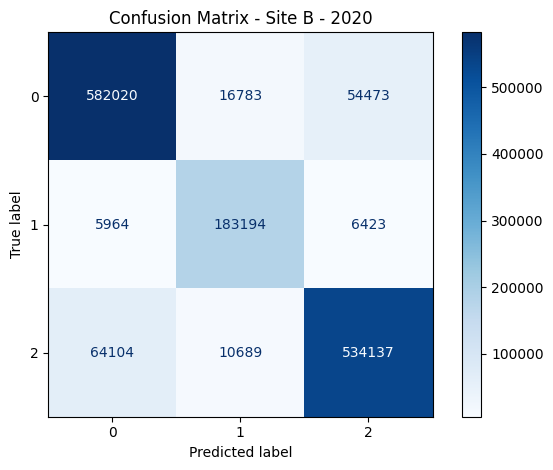


Saved labeled data for predictive_entropy to true_BCNN_selected_data/true_BCNN_data_predictive_entropy.npz

 Running strategy: BALD 
Length of Labeled Pool: 0
Length of Unlabeled Pool: 388743
Length of Labeled Pool: 4000
Length of Unlabeled Pool: 384743
Class weights: tensor([0.7432, 1.2500, 0.8061], device='cuda:0')

-> Training on 4000 initially labeled samples 


Training Epoch 1: 100%|██████████| 63/63 [00:01<00:00, 42.35it/s]


Loss: 0.3149 + 1e-08 * 2859878.5
Loss: 0.3149 + 0.028598785400390625
Epoch [1/20] Train Loss: 1.0212, Train Acc: 0.6765


Training Epoch 2: 100%|██████████| 63/63 [00:01<00:00, 42.75it/s]


Loss: 0.2907 + 1e-08 * 2851762.75
Loss: 0.2907 + 0.028517628088593483
Epoch [2/20] Train Loss: 0.5663, Train Acc: 0.7940


Training Epoch 3: 100%|██████████| 63/63 [00:01<00:00, 42.75it/s]


Loss: 0.5620 + 1e-08 * 2842175.0
Loss: 0.5620 + 0.02842175029218197
Epoch [3/20] Train Loss: 0.5032, Train Acc: 0.8143


Training Epoch 4: 100%|██████████| 63/63 [00:01<00:00, 42.52it/s]


Loss: 0.4894 + 1e-08 * 2830516.0
Loss: 0.4894 + 0.028305159881711006
Epoch [4/20] Train Loss: 0.4409, Train Acc: 0.8410


Training Epoch 5: 100%|██████████| 63/63 [00:01<00:00, 42.74it/s]


Loss: 0.4402 + 1e-08 * 2819471.5
Loss: 0.4402 + 0.028194714337587357
Epoch [5/20] Train Loss: 0.4364, Train Acc: 0.8337


Training Epoch 6: 100%|██████████| 63/63 [00:01<00:00, 42.60it/s]


Loss: 0.7494 + 1e-08 * 2808024.75
Loss: 0.7494 + 0.028080247342586517
Epoch [6/20] Train Loss: 0.4122, Train Acc: 0.8488


Training Epoch 7: 100%|██████████| 63/63 [00:01<00:00, 42.47it/s]


Loss: 0.3038 + 1e-08 * 2796783.75
Loss: 0.3038 + 0.02796783670783043
Epoch [7/20] Train Loss: 0.3936, Train Acc: 0.8532


Training Epoch 8: 100%|██████████| 63/63 [00:01<00:00, 42.40it/s]


Loss: 0.2773 + 1e-08 * 2785594.0
Loss: 0.2773 + 0.02785594016313553
Epoch [8/20] Train Loss: 0.3892, Train Acc: 0.8522


Training Epoch 9: 100%|██████████| 63/63 [00:01<00:00, 42.75it/s]


Loss: 0.2702 + 1e-08 * 2773615.25
Loss: 0.2702 + 0.027736151590943336
Epoch [9/20] Train Loss: 0.3743, Train Acc: 0.8608


Training Epoch 10: 100%|██████████| 63/63 [00:01<00:00, 43.02it/s]


Loss: 0.4637 + 1e-08 * 2761979.0
Loss: 0.4637 + 0.02761979028582573
Epoch [10/20] Train Loss: 0.3710, Train Acc: 0.8640


Training Epoch 11: 100%|██████████| 63/63 [00:01<00:00, 42.18it/s]


Loss: 0.3202 + 1e-08 * 2750123.75
Loss: 0.3202 + 0.027501236647367477
Epoch [11/20] Train Loss: 0.3655, Train Acc: 0.8632


Training Epoch 12: 100%|██████████| 63/63 [00:01<00:00, 42.49it/s]


Loss: 0.3174 + 1e-08 * 2739187.75
Loss: 0.3174 + 0.02739187702536583
Epoch [12/20] Train Loss: 0.3511, Train Acc: 0.8655


Training Epoch 13: 100%|██████████| 63/63 [00:01<00:00, 42.68it/s]


Loss: 0.3908 + 1e-08 * 2727521.5
Loss: 0.3908 + 0.027275213971734047
Epoch [13/20] Train Loss: 0.3567, Train Acc: 0.8695


Training Epoch 14: 100%|██████████| 63/63 [00:01<00:00, 42.44it/s]


Loss: 0.2906 + 1e-08 * 2717959.75
Loss: 0.2906 + 0.027179596945643425
Epoch [14/20] Train Loss: 0.3514, Train Acc: 0.8698


Training Epoch 15: 100%|██████████| 63/63 [00:01<00:00, 42.78it/s]


Loss: 0.4471 + 1e-08 * 2706745.25
Loss: 0.4471 + 0.027067452669143677
Epoch [15/20] Train Loss: 0.3399, Train Acc: 0.8678


Training Epoch 16: 100%|██████████| 63/63 [00:01<00:00, 42.82it/s]


Loss: 0.6012 + 1e-08 * 2696750.25
Loss: 0.6012 + 0.026967503130435944
Epoch [16/20] Train Loss: 0.3486, Train Acc: 0.8718


Training Epoch 17: 100%|██████████| 63/63 [00:01<00:00, 42.73it/s]


Loss: 0.1309 + 1e-08 * 2687898.25
Loss: 0.1309 + 0.02687898278236389
Epoch [17/20] Train Loss: 0.3336, Train Acc: 0.8785


Training Epoch 18: 100%|██████████| 63/63 [00:01<00:00, 42.34it/s]


Loss: 0.1556 + 1e-08 * 2676916.75
Loss: 0.1556 + 0.026769166812300682
Epoch [18/20] Train Loss: 0.3221, Train Acc: 0.8788


Training Epoch 19: 100%|██████████| 63/63 [00:01<00:00, 42.67it/s]


Loss: 0.3261 + 1e-08 * 2666947.25
Loss: 0.3261 + 0.026669472455978394
Epoch [19/20] Train Loss: 0.3085, Train Acc: 0.8840


Training Epoch 20: 100%|██████████| 63/63 [00:01<00:00, 42.99it/s]


Loss: 0.1382 + 1e-08 * 2658075.0
Loss: 0.1382 + 0.026580749079585075
Epoch [20/20] Train Loss: 0.3160, Train Acc: 0.8842


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 136.15it/s]


Per-class F1 scores: [0.88786527 0.90742279 0.88518728]
Validation Accuracy: 88.93%
Validation Loss: 0.3126
Average F1 Score: 0.8935
Kappa: 0.8166

--- Round 1 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 10/10 [06:33<00:00, 39.32s/it]


Length of Labeled Pool: 5000
Length of Unlabeled Pool: 383743


Training Epoch 1: 100%|██████████| 79/79 [00:01<00:00, 42.17it/s]


Loss: 0.4723 + 1e-08 * 2644494.5
Loss: 0.4723 + 0.026444945484399796
Epoch [1/20] Train Loss: 0.3760, Train Acc: 0.8620


Training Epoch 2: 100%|██████████| 79/79 [00:01<00:00, 42.43it/s]


Loss: 0.1453 + 1e-08 * 2634956.0
Loss: 0.1453 + 0.026349559426307678
Epoch [2/20] Train Loss: 0.3557, Train Acc: 0.8694


Training Epoch 3: 100%|██████████| 79/79 [00:01<00:00, 42.15it/s]


Loss: 0.8552 + 1e-08 * 2625327.25
Loss: 0.8552 + 0.026253271847963333
Epoch [3/20] Train Loss: 0.3535, Train Acc: 0.8712


Training Epoch 4: 100%|██████████| 79/79 [00:01<00:00, 42.22it/s]


Loss: 0.3721 + 1e-08 * 2615229.25
Loss: 0.3721 + 0.026152292266488075
Epoch [4/20] Train Loss: 0.3381, Train Acc: 0.8760


Training Epoch 5: 100%|██████████| 79/79 [00:01<00:00, 42.20it/s]


Loss: 1.0710 + 1e-08 * 2604249.75
Loss: 1.0710 + 0.026042496785521507
Epoch [5/20] Train Loss: 0.3341, Train Acc: 0.8794


Training Epoch 6: 100%|██████████| 79/79 [00:01<00:00, 42.18it/s]


Loss: 1.0918 + 1e-08 * 2597327.75
Loss: 1.0918 + 0.025973277166485786
Epoch [6/20] Train Loss: 0.3190, Train Acc: 0.8854


Training Epoch 7: 100%|██████████| 79/79 [00:01<00:00, 42.58it/s]


Loss: 0.7036 + 1e-08 * 2588390.5
Loss: 0.7036 + 0.025883905589580536
Epoch [7/20] Train Loss: 0.3217, Train Acc: 0.8854


Training Epoch 8: 100%|██████████| 79/79 [00:01<00:00, 42.52it/s]


Loss: 0.5146 + 1e-08 * 2578255.75
Loss: 0.5146 + 0.02578255720436573
Epoch [8/20] Train Loss: 0.3007, Train Acc: 0.8890


Training Epoch 9: 100%|██████████| 79/79 [00:01<00:00, 42.77it/s]


Loss: 0.5902 + 1e-08 * 2569665.75
Loss: 0.5902 + 0.025696657598018646
Epoch [9/20] Train Loss: 0.3042, Train Acc: 0.8878


Training Epoch 10: 100%|██████████| 79/79 [00:01<00:00, 42.67it/s]


Loss: 0.1362 + 1e-08 * 2560550.25
Loss: 0.1362 + 0.025605501607060432
Epoch [10/20] Train Loss: 0.3053, Train Acc: 0.8924


Training Epoch 11: 100%|██████████| 79/79 [00:01<00:00, 42.65it/s]


Loss: 0.8036 + 1e-08 * 2552378.75
Loss: 0.8036 + 0.02552378736436367
Epoch [11/20] Train Loss: 0.3084, Train Acc: 0.8878


Training Epoch 12: 100%|██████████| 79/79 [00:01<00:00, 42.32it/s]


Loss: 0.6109 + 1e-08 * 2543990.5
Loss: 0.6109 + 0.025439905002713203
Epoch [12/20] Train Loss: 0.3036, Train Acc: 0.8934


Training Epoch 13: 100%|██████████| 79/79 [00:01<00:00, 42.92it/s]


Loss: 0.3398 + 1e-08 * 2534600.25
Loss: 0.3398 + 0.025346001610159874
Epoch [13/20] Train Loss: 0.2991, Train Acc: 0.8924


Training Epoch 14: 100%|██████████| 79/79 [00:01<00:00, 42.73it/s]


Loss: 0.3213 + 1e-08 * 2526107.0
Loss: 0.3213 + 0.02526107057929039
Epoch [14/20] Train Loss: 0.2955, Train Acc: 0.8928


Training Epoch 15: 100%|██████████| 79/79 [00:01<00:00, 42.96it/s]


Loss: 0.7244 + 1e-08 * 2516150.25
Loss: 0.7244 + 0.02516150288283825
Epoch [15/20] Train Loss: 0.2920, Train Acc: 0.8928


Training Epoch 16: 100%|██████████| 79/79 [00:01<00:00, 42.56it/s]


Loss: 0.5641 + 1e-08 * 2507121.25
Loss: 0.5641 + 0.025071213021874428
Epoch [16/20] Train Loss: 0.2819, Train Acc: 0.9028


Training Epoch 17: 100%|██████████| 79/79 [00:01<00:00, 42.50it/s]


Loss: 0.3592 + 1e-08 * 2496104.75
Loss: 0.3592 + 0.024961046874523163
Epoch [17/20] Train Loss: 0.2705, Train Acc: 0.9016


Training Epoch 18: 100%|██████████| 79/79 [00:01<00:00, 42.58it/s]


Loss: 0.0481 + 1e-08 * 2486789.25
Loss: 0.0481 + 0.024867892265319824
Epoch [18/20] Train Loss: 0.2758, Train Acc: 0.9054


Training Epoch 19: 100%|██████████| 79/79 [00:01<00:00, 42.64it/s]


Loss: 0.1153 + 1e-08 * 2476788.25
Loss: 0.1153 + 0.024767883121967316
Epoch [19/20] Train Loss: 0.2703, Train Acc: 0.9076


Training Epoch 20: 100%|██████████| 79/79 [00:01<00:00, 42.77it/s]


Loss: 0.2081 + 1e-08 * 2467332.0
Loss: 0.2081 + 0.02467332035303116
Epoch [20/20] Train Loss: 0.2748, Train Acc: 0.9020


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 135.15it/s]


Per-class F1 scores: [0.89321321 0.90534445 0.88531719]
Validation Accuracy: 89.17%
Validation Loss: 0.3120
Average F1 Score: 0.8946
Kappa: 0.8213

--- Round 2 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 10/10 [06:33<00:00, 39.31s/it]


Length of Labeled Pool: 6000
Length of Unlabeled Pool: 382743


Training Epoch 1: 100%|██████████| 94/94 [00:02<00:00, 42.19it/s]


Loss: 0.1980 + 1e-08 * 2452193.25
Loss: 0.1980 + 0.024521932005882263
Epoch [1/20] Train Loss: 0.2739, Train Acc: 0.9075


Training Epoch 2: 100%|██████████| 94/94 [00:02<00:00, 42.43it/s]


Loss: 0.1812 + 1e-08 * 2441392.75
Loss: 0.1812 + 0.024413926526904106
Epoch [2/20] Train Loss: 0.2538, Train Acc: 0.9113


Training Epoch 3: 100%|██████████| 94/94 [00:02<00:00, 42.04it/s]


Loss: 0.1672 + 1e-08 * 2431383.0
Loss: 0.1672 + 0.024313829839229584
Epoch [3/20] Train Loss: 0.2442, Train Acc: 0.9137


Training Epoch 4: 100%|██████████| 94/94 [00:02<00:00, 42.62it/s]


Loss: 0.1202 + 1e-08 * 2422292.5
Loss: 0.1202 + 0.024222925305366516
Epoch [4/20] Train Loss: 0.2575, Train Acc: 0.9060


Training Epoch 5: 100%|██████████| 94/94 [00:02<00:00, 42.36it/s]


Loss: 0.1966 + 1e-08 * 2413443.0
Loss: 0.1966 + 0.024134429171681404
Epoch [5/20] Train Loss: 0.2459, Train Acc: 0.9132


Training Epoch 6: 100%|██████████| 94/94 [00:02<00:00, 42.61it/s]


Loss: 0.2655 + 1e-08 * 2403134.75
Loss: 0.2655 + 0.024031346663832664
Epoch [6/20] Train Loss: 0.2452, Train Acc: 0.9175


Training Epoch 7: 100%|██████████| 94/94 [00:02<00:00, 42.47it/s]


Loss: 0.4452 + 1e-08 * 2392596.75
Loss: 0.4452 + 0.023925967514514923
Epoch [7/20] Train Loss: 0.2412, Train Acc: 0.9145


Training Epoch 8: 100%|██████████| 94/94 [00:02<00:00, 41.96it/s]


Loss: 0.1304 + 1e-08 * 2383986.5
Loss: 0.1304 + 0.023839864879846573
Epoch [8/20] Train Loss: 0.2503, Train Acc: 0.9130


Training Epoch 9: 100%|██████████| 94/94 [00:02<00:00, 41.80it/s]


Loss: 0.1278 + 1e-08 * 2376054.0
Loss: 0.1278 + 0.023760540410876274
Epoch [9/20] Train Loss: 0.2443, Train Acc: 0.9185


Training Epoch 10: 100%|██████████| 94/94 [00:02<00:00, 42.01it/s]


Loss: 0.2403 + 1e-08 * 2369314.25
Loss: 0.2403 + 0.0236931424587965
Epoch [10/20] Train Loss: 0.2345, Train Acc: 0.9187


Training Epoch 11: 100%|██████████| 94/94 [00:02<00:00, 41.79it/s]


Loss: 0.1452 + 1e-08 * 2360080.0
Loss: 0.1452 + 0.023600799962878227
Epoch [11/20] Train Loss: 0.2321, Train Acc: 0.9220


Training Epoch 12: 100%|██████████| 94/94 [00:02<00:00, 42.19it/s]


Loss: 0.1611 + 1e-08 * 2351508.0
Loss: 0.1611 + 0.02351507917046547
Epoch [12/20] Train Loss: 0.2261, Train Acc: 0.9232


Training Epoch 13: 100%|██████████| 94/94 [00:02<00:00, 42.01it/s]


Loss: 0.2246 + 1e-08 * 2342822.0
Loss: 0.2246 + 0.02342822030186653
Epoch [13/20] Train Loss: 0.2309, Train Acc: 0.9150


Training Epoch 14: 100%|██████████| 94/94 [00:02<00:00, 42.04it/s]


Loss: 0.2005 + 1e-08 * 2335096.5
Loss: 0.2005 + 0.023350965231657028
Epoch [14/20] Train Loss: 0.2263, Train Acc: 0.9233


Training Epoch 15: 100%|██████████| 94/94 [00:02<00:00, 42.50it/s]


Loss: 0.0990 + 1e-08 * 2328854.5
Loss: 0.0990 + 0.023288544267416
Epoch [15/20] Train Loss: 0.2169, Train Acc: 0.9215


Training Epoch 16: 100%|██████████| 94/94 [00:02<00:00, 42.33it/s]


Loss: 0.3077 + 1e-08 * 2320075.0
Loss: 0.3077 + 0.02320075035095215
Epoch [16/20] Train Loss: 0.2214, Train Acc: 0.9230


Training Epoch 17: 100%|██████████| 94/94 [00:02<00:00, 42.49it/s]


Loss: 0.0923 + 1e-08 * 2313452.0
Loss: 0.0923 + 0.023134520277380943
Epoch [17/20] Train Loss: 0.2196, Train Acc: 0.9253


Training Epoch 18: 100%|██████████| 94/94 [00:02<00:00, 42.16it/s]


Loss: 0.1456 + 1e-08 * 2305349.75
Loss: 0.1456 + 0.023053497076034546
Epoch [18/20] Train Loss: 0.2179, Train Acc: 0.9238


Training Epoch 19: 100%|██████████| 94/94 [00:02<00:00, 42.19it/s]


Loss: 0.2724 + 1e-08 * 2298263.0
Loss: 0.2724 + 0.022982629016041756
Epoch [19/20] Train Loss: 0.2201, Train Acc: 0.9253


Training Epoch 20: 100%|██████████| 94/94 [00:02<00:00, 42.75it/s]


Loss: 0.1762 + 1e-08 * 2289211.5
Loss: 0.1762 + 0.022892115637660027
Epoch [20/20] Train Loss: 0.2077, Train Acc: 0.9285


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 135.72it/s]


Per-class F1 scores: [0.89351554 0.90450012 0.88835839]
Validation Accuracy: 89.29%
Validation Loss: 0.3324
Average F1 Score: 0.8955
Kappa: 0.8226

--- Round 3 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 10/10 [06:32<00:00, 39.24s/it]


Length of Labeled Pool: 7000
Length of Unlabeled Pool: 381743


Training Epoch 1: 100%|██████████| 110/110 [00:02<00:00, 42.30it/s]


Loss: 0.1857 + 1e-08 * 2273064.75
Loss: 0.1857 + 0.022730646654963493
Epoch [1/20] Train Loss: 0.2770, Train Acc: 0.8990


Training Epoch 2: 100%|██████████| 110/110 [00:02<00:00, 42.75it/s]


Loss: 0.1309 + 1e-08 * 2262919.0
Loss: 0.1309 + 0.022629190236330032
Epoch [2/20] Train Loss: 0.2684, Train Acc: 0.9029


Training Epoch 3: 100%|██████████| 110/110 [00:02<00:00, 42.90it/s]


Loss: 0.1098 + 1e-08 * 2254358.25
Loss: 0.1098 + 0.022543583065271378
Epoch [3/20] Train Loss: 0.2634, Train Acc: 0.9013


Training Epoch 4: 100%|██████████| 110/110 [00:02<00:00, 42.70it/s]


Loss: 0.3548 + 1e-08 * 2245620.5
Loss: 0.3548 + 0.022456204518675804
Epoch [4/20] Train Loss: 0.2491, Train Acc: 0.9111


Training Epoch 5: 100%|██████████| 110/110 [00:02<00:00, 42.50it/s]


Loss: 0.0701 + 1e-08 * 2236900.5
Loss: 0.0701 + 0.022369004786014557
Epoch [5/20] Train Loss: 0.2457, Train Acc: 0.9090


Training Epoch 6: 100%|██████████| 110/110 [00:02<00:00, 42.90it/s]


Loss: 0.3368 + 1e-08 * 2229154.5
Loss: 0.3368 + 0.02229154482483864
Epoch [6/20] Train Loss: 0.2438, Train Acc: 0.9110


Training Epoch 7: 100%|██████████| 110/110 [00:02<00:00, 42.78it/s]


Loss: 0.2263 + 1e-08 * 2224279.0
Loss: 0.2263 + 0.022242790088057518
Epoch [7/20] Train Loss: 0.2486, Train Acc: 0.9137


Training Epoch 8: 100%|██████████| 110/110 [00:02<00:00, 42.75it/s]


Loss: 0.1795 + 1e-08 * 2216021.25
Loss: 0.1795 + 0.022160211578011513
Epoch [8/20] Train Loss: 0.2456, Train Acc: 0.9103


Training Epoch 9: 100%|██████████| 110/110 [00:02<00:00, 42.59it/s]


Loss: 0.1748 + 1e-08 * 2208638.25
Loss: 0.1748 + 0.022086381912231445
Epoch [9/20] Train Loss: 0.2470, Train Acc: 0.9084


Training Epoch 10: 100%|██████████| 110/110 [00:02<00:00, 42.88it/s]


Loss: 0.0863 + 1e-08 * 2200503.5
Loss: 0.0863 + 0.02200503461062908
Epoch [10/20] Train Loss: 0.2378, Train Acc: 0.9126


Training Epoch 11: 100%|██████████| 110/110 [00:02<00:00, 42.70it/s]


Loss: 0.3146 + 1e-08 * 2192978.25
Loss: 0.3146 + 0.021929781883955002
Epoch [11/20] Train Loss: 0.2386, Train Acc: 0.9129


Training Epoch 12: 100%|██████████| 110/110 [00:02<00:00, 42.68it/s]


Loss: 0.1177 + 1e-08 * 2185431.25
Loss: 0.1177 + 0.02185431309044361
Epoch [12/20] Train Loss: 0.2327, Train Acc: 0.9150


Training Epoch 13: 100%|██████████| 110/110 [00:02<00:00, 42.42it/s]


Loss: 0.1759 + 1e-08 * 2179942.5
Loss: 0.1759 + 0.021799424663186073
Epoch [13/20] Train Loss: 0.2359, Train Acc: 0.9127


Training Epoch 14: 100%|██████████| 110/110 [00:02<00:00, 42.80it/s]


Loss: 0.3535 + 1e-08 * 2171953.25
Loss: 0.3535 + 0.02171953208744526
Epoch [14/20] Train Loss: 0.2276, Train Acc: 0.9161


Training Epoch 15: 100%|██████████| 110/110 [00:02<00:00, 42.92it/s]


Loss: 0.3429 + 1e-08 * 2165312.75
Loss: 0.3429 + 0.021653126925230026
Epoch [15/20] Train Loss: 0.2227, Train Acc: 0.9219


Training Epoch 16: 100%|██████████| 110/110 [00:02<00:00, 42.67it/s]


Loss: 0.1730 + 1e-08 * 2160089.5
Loss: 0.1730 + 0.021600894629955292
Epoch [16/20] Train Loss: 0.2332, Train Acc: 0.9123


Training Epoch 17: 100%|██████████| 110/110 [00:02<00:00, 42.18it/s]


Loss: 0.1626 + 1e-08 * 2153480.5
Loss: 0.1626 + 0.02153480425477028
Epoch [17/20] Train Loss: 0.2197, Train Acc: 0.9184


Training Epoch 18: 100%|██████████| 110/110 [00:02<00:00, 42.83it/s]


Loss: 0.1239 + 1e-08 * 2148222.0
Loss: 0.1239 + 0.02148221991956234
Epoch [18/20] Train Loss: 0.2199, Train Acc: 0.9206


Training Epoch 19: 100%|██████████| 110/110 [00:02<00:00, 42.69it/s]


Loss: 0.1154 + 1e-08 * 2140861.5
Loss: 0.1154 + 0.02140861563384533
Epoch [19/20] Train Loss: 0.2304, Train Acc: 0.9201


Training Epoch 20: 100%|██████████| 110/110 [00:02<00:00, 42.27it/s]


Loss: 0.2268 + 1e-08 * 2134605.25
Loss: 0.2268 + 0.02134605310857296
Epoch [20/20] Train Loss: 0.2211, Train Acc: 0.9217


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 135.33it/s]


Per-class F1 scores: [0.89527327 0.91244779 0.89386592]
Validation Accuracy: 89.70%
Validation Loss: 0.3281
Average F1 Score: 0.9005
Kappa: 0.8297

--- Round 4 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 10/10 [06:30<00:00, 39.06s/it]


Length of Labeled Pool: 8000
Length of Unlabeled Pool: 380743


Training Epoch 1: 100%|██████████| 125/125 [00:02<00:00, 42.10it/s]


Loss: 0.2456 + 1e-08 * 2121997.75
Loss: 0.2456 + 0.021219978109002113
Epoch [1/20] Train Loss: 0.2906, Train Acc: 0.8920


Training Epoch 2: 100%|██████████| 125/125 [00:02<00:00, 42.44it/s]


Loss: 0.2787 + 1e-08 * 2114868.5
Loss: 0.2787 + 0.0211486853659153
Epoch [2/20] Train Loss: 0.2735, Train Acc: 0.9028


Training Epoch 3: 100%|██████████| 125/125 [00:02<00:00, 41.99it/s]


Loss: 0.2052 + 1e-08 * 2108014.75
Loss: 0.2052 + 0.021080147475004196
Epoch [3/20] Train Loss: 0.2679, Train Acc: 0.8978


Training Epoch 4: 100%|██████████| 125/125 [00:02<00:00, 42.14it/s]


Loss: 0.2684 + 1e-08 * 2101641.25
Loss: 0.2684 + 0.02101641148328781
Epoch [4/20] Train Loss: 0.2611, Train Acc: 0.9058


Training Epoch 5: 100%|██████████| 125/125 [00:02<00:00, 42.14it/s]


Loss: 0.2097 + 1e-08 * 2094484.75
Loss: 0.2097 + 0.02094484679400921
Epoch [5/20] Train Loss: 0.2604, Train Acc: 0.9046


Training Epoch 6: 100%|██████████| 125/125 [00:02<00:00, 41.93it/s]


Loss: 0.1177 + 1e-08 * 2087556.0
Loss: 0.1177 + 0.020875560119748116
Epoch [6/20] Train Loss: 0.2642, Train Acc: 0.9020


Training Epoch 7: 100%|██████████| 125/125 [00:02<00:00, 42.13it/s]


Loss: 0.2372 + 1e-08 * 2082121.125
Loss: 0.2372 + 0.020821211859583855
Epoch [7/20] Train Loss: 0.2717, Train Acc: 0.8994


Training Epoch 8: 100%|██████████| 125/125 [00:02<00:00, 42.68it/s]


Loss: 0.2820 + 1e-08 * 2076253.125
Loss: 0.2820 + 0.020762531086802483
Epoch [8/20] Train Loss: 0.2528, Train Acc: 0.9024


Training Epoch 9: 100%|██████████| 125/125 [00:02<00:00, 42.68it/s]


Loss: 0.2007 + 1e-08 * 2069518.125
Loss: 0.2007 + 0.02069518156349659
Epoch [9/20] Train Loss: 0.2497, Train Acc: 0.9097


Training Epoch 10: 100%|██████████| 125/125 [00:02<00:00, 42.20it/s]


Loss: 0.2403 + 1e-08 * 2065139.75
Loss: 0.2403 + 0.020651398226618767
Epoch [10/20] Train Loss: 0.2560, Train Acc: 0.9031


Training Epoch 11: 100%|██████████| 125/125 [00:02<00:00, 41.92it/s]


Loss: 0.2861 + 1e-08 * 2062774.5
Loss: 0.2861 + 0.020627744495868683
Epoch [11/20] Train Loss: 0.2440, Train Acc: 0.9117


Training Epoch 12: 100%|██████████| 125/125 [00:02<00:00, 41.85it/s]


Loss: 0.1084 + 1e-08 * 2057357.875
Loss: 0.1084 + 0.020573578774929047
Epoch [12/20] Train Loss: 0.2442, Train Acc: 0.9095


Training Epoch 13: 100%|██████████| 125/125 [00:03<00:00, 41.17it/s]


Loss: 0.1075 + 1e-08 * 2053792.75
Loss: 0.1075 + 0.020537927746772766
Epoch [13/20] Train Loss: 0.2444, Train Acc: 0.9106


Training Epoch 14: 100%|██████████| 125/125 [00:03<00:00, 41.51it/s]


Loss: 0.2437 + 1e-08 * 2048983.25
Loss: 0.2437 + 0.020489832386374474
Epoch [14/20] Train Loss: 0.2469, Train Acc: 0.9094


Training Epoch 15: 100%|██████████| 125/125 [00:03<00:00, 41.65it/s]


Loss: 0.1562 + 1e-08 * 2044148.5
Loss: 0.1562 + 0.020441485568881035
Epoch [15/20] Train Loss: 0.2414, Train Acc: 0.9129


MC Dropout Simulations (BALD): 100%|██████████| 10/10 [06:29<00:00, 38.91s/it]


Length of Labeled Pool: 9000
Length of Unlabeled Pool: 379743


Training Epoch 1: 100%|██████████| 141/141 [00:03<00:00, 42.84it/s]


Loss: 0.2892 + 1e-08 * 2009869.25
Loss: 0.2892 + 0.020098691806197166
Epoch [1/20] Train Loss: 0.2898, Train Acc: 0.8931


Training Epoch 2: 100%|██████████| 141/141 [00:03<00:00, 42.64it/s]


Loss: 0.4076 + 1e-08 * 2004744.125
Loss: 0.4076 + 0.020047441124916077
Epoch [2/20] Train Loss: 0.2773, Train Acc: 0.8987


Training Epoch 3: 100%|██████████| 141/141 [00:03<00:00, 42.05it/s]


Loss: 0.2198 + 1e-08 * 1999354.5
Loss: 0.2198 + 0.01999354548752308
Epoch [3/20] Train Loss: 0.2726, Train Acc: 0.8977


Training Epoch 4: 100%|██████████| 141/141 [00:03<00:00, 42.67it/s]


Loss: 0.3308 + 1e-08 * 1994950.0
Loss: 0.3308 + 0.019949499517679214
Epoch [4/20] Train Loss: 0.2728, Train Acc: 0.8974


Training Epoch 5: 100%|██████████| 141/141 [00:03<00:00, 42.56it/s]


Loss: 0.1368 + 1e-08 * 1989433.125
Loss: 0.1368 + 0.019894331693649292
Epoch [5/20] Train Loss: 0.2708, Train Acc: 0.8957


Training Epoch 6: 100%|██████████| 141/141 [00:03<00:00, 42.54it/s]


Loss: 0.1521 + 1e-08 * 1983350.125
Loss: 0.1521 + 0.019833501428365707
Epoch [6/20] Train Loss: 0.2692, Train Acc: 0.8972


Training Epoch 7: 100%|██████████| 141/141 [00:03<00:00, 42.50it/s]


Loss: 0.1913 + 1e-08 * 1978409.0
Loss: 0.1913 + 0.01978408917784691
Epoch [7/20] Train Loss: 0.2616, Train Acc: 0.8994


Training Epoch 8: 100%|██████████| 141/141 [00:03<00:00, 42.60it/s]


Loss: 0.3338 + 1e-08 * 1973554.0
Loss: 0.3338 + 0.019735539332032204
Epoch [8/20] Train Loss: 0.2570, Train Acc: 0.9073


Training Epoch 9: 100%|██████████| 141/141 [00:03<00:00, 41.96it/s]


Loss: 0.2223 + 1e-08 * 1970252.0
Loss: 0.2223 + 0.019702520221471786
Epoch [9/20] Train Loss: 0.2576, Train Acc: 0.9023


Training Epoch 10: 100%|██████████| 141/141 [00:03<00:00, 42.25it/s]


Loss: 0.2647 + 1e-08 * 1967214.75
Loss: 0.2647 + 0.019672147929668427
Epoch [10/20] Train Loss: 0.2549, Train Acc: 0.9051


Training Epoch 11: 100%|██████████| 141/141 [00:03<00:00, 42.46it/s]


Loss: 0.0973 + 1e-08 * 1960946.0
Loss: 0.0973 + 0.01960946060717106
Epoch [11/20] Train Loss: 0.2547, Train Acc: 0.9076


Training Epoch 12: 100%|██████████| 141/141 [00:03<00:00, 42.24it/s]


Loss: 0.1803 + 1e-08 * 1957782.125
Loss: 0.1803 + 0.01957782171666622
Epoch [12/20] Train Loss: 0.2558, Train Acc: 0.9037


Training Epoch 13: 100%|██████████| 141/141 [00:03<00:00, 42.27it/s]


Loss: 0.2630 + 1e-08 * 1954595.875
Loss: 0.2630 + 0.019545959308743477
Epoch [13/20] Train Loss: 0.2498, Train Acc: 0.9047


Training Epoch 14: 100%|██████████| 141/141 [00:03<00:00, 42.37it/s]


Loss: 0.2201 + 1e-08 * 1950023.0
Loss: 0.2201 + 0.019500229507684708
Epoch [14/20] Train Loss: 0.2489, Train Acc: 0.9073


Training Epoch 15: 100%|██████████| 141/141 [00:03<00:00, 42.47it/s]


Loss: 0.1654 + 1e-08 * 1945449.375
Loss: 0.1654 + 0.01945449411869049
Epoch [15/20] Train Loss: 0.2481, Train Acc: 0.9068


Training Epoch 16: 100%|██████████| 141/141 [00:03<00:00, 42.41it/s]


Loss: 0.2014 + 1e-08 * 1940332.375
Loss: 0.2014 + 0.019403323531150818
Epoch [16/20] Train Loss: 0.2457, Train Acc: 0.9113


Training Epoch 17: 100%|██████████| 141/141 [00:03<00:00, 42.42it/s]


Loss: 0.1311 + 1e-08 * 1937303.125
Loss: 0.1311 + 0.019373031333088875
Epoch [17/20] Train Loss: 0.2463, Train Acc: 0.9096


Training Epoch 18: 100%|██████████| 141/141 [00:03<00:00, 42.20it/s]


Loss: 0.2421 + 1e-08 * 1933163.25
Loss: 0.2421 + 0.019331632182002068
Epoch [18/20] Train Loss: 0.2372, Train Acc: 0.9110


Training Epoch 19: 100%|██████████| 141/141 [00:03<00:00, 42.47it/s]


Loss: 0.1665 + 1e-08 * 1930626.25
Loss: 0.1665 + 0.019306262955069542
Epoch [19/20] Train Loss: 0.2424, Train Acc: 0.9121


Training Epoch 20: 100%|██████████| 141/141 [00:03<00:00, 42.29it/s]


Loss: 0.2692 + 1e-08 * 1928854.625
Loss: 0.2692 + 0.019288545474410057
Epoch [20/20] Train Loss: 0.2427, Train Acc: 0.9113


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 135.29it/s]


Per-class F1 scores: [0.90031156 0.91117834 0.89588547]
Validation Accuracy: 89.99%
Validation Loss: 0.3120
Average F1 Score: 0.9025
Kappa: 0.8347

--- Round 6 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 10/10 [06:27<00:00, 38.78s/it]


Length of Labeled Pool: 10000
Length of Unlabeled Pool: 378743


Training Epoch 1: 100%|██████████| 157/157 [00:03<00:00, 42.45it/s]


Loss: 0.3375 + 1e-08 * 1918373.625
Loss: 0.3375 + 0.01918373629450798
Epoch [1/20] Train Loss: 0.2867, Train Acc: 0.8927


Training Epoch 2: 100%|██████████| 157/157 [00:03<00:00, 42.71it/s]


Loss: 0.2983 + 1e-08 * 1913911.625
Loss: 0.2983 + 0.019139116629958153
Epoch [2/20] Train Loss: 0.2782, Train Acc: 0.8922


Training Epoch 3: 100%|██████████| 157/157 [00:03<00:00, 42.62it/s]


Loss: 0.2472 + 1e-08 * 1910056.5
Loss: 0.2472 + 0.01910056546330452
Epoch [3/20] Train Loss: 0.2894, Train Acc: 0.8885


Training Epoch 4: 100%|██████████| 157/157 [00:03<00:00, 42.62it/s]


Loss: 0.3338 + 1e-08 * 1905917.0
Loss: 0.3338 + 0.01905917003750801
Epoch [4/20] Train Loss: 0.2823, Train Acc: 0.8931


Training Epoch 12: 100%|██████████| 157/157 [00:03<00:00, 42.25it/s]


Loss: 0.6706 + 1e-08 * 1876320.75
Loss: 0.6706 + 0.018763206899166107
Epoch [12/20] Train Loss: 0.2630, Train Acc: 0.9027


Training Epoch 13: 100%|██████████| 157/157 [00:03<00:00, 42.73it/s]


Loss: 0.8645 + 1e-08 * 1875213.0
Loss: 0.8645 + 0.01875212974846363
Epoch [13/20] Train Loss: 0.2580, Train Acc: 0.9046


Training Epoch 14: 100%|██████████| 157/157 [00:03<00:00, 42.37it/s]


Loss: 0.3744 + 1e-08 * 1873199.625
Loss: 0.3744 + 0.018731996417045593
Epoch [14/20] Train Loss: 0.2700, Train Acc: 0.8962


Training Epoch 15: 100%|██████████| 157/157 [00:03<00:00, 42.22it/s]


Loss: 0.4944 + 1e-08 * 1871207.75
Loss: 0.4944 + 0.018712077289819717
Epoch [15/20] Train Loss: 0.2481, Train Acc: 0.9090


Training Epoch 16: 100%|██████████| 157/157 [00:03<00:00, 41.76it/s]


Loss: 0.4245 + 1e-08 * 1867853.25
Loss: 0.4245 + 0.018678532913327217
Epoch [16/20] Train Loss: 0.2591, Train Acc: 0.8984


Training Epoch 17: 100%|██████████| 157/157 [00:03<00:00, 41.50it/s]


Loss: 0.1948 + 1e-08 * 1865299.5
Loss: 0.1948 + 0.01865299418568611
Epoch [17/20] Train Loss: 0.2536, Train Acc: 0.9045


Training Epoch 18: 100%|██████████| 157/157 [00:03<00:00, 41.96it/s]


Loss: 0.3646 + 1e-08 * 1862841.5
Loss: 0.3646 + 0.01862841472029686
Epoch [18/20] Train Loss: 0.2542, Train Acc: 0.9015


Training Epoch 19: 100%|██████████| 157/157 [00:03<00:00, 42.34it/s]


Loss: 0.1707 + 1e-08 * 1860286.0
Loss: 0.1707 + 0.01860285922884941
Epoch [19/20] Train Loss: 0.2532, Train Acc: 0.9051


Training Epoch 20: 100%|██████████| 157/157 [00:03<00:00, 42.11it/s]


Loss: 0.0722 + 1e-08 * 1857205.625
Loss: 0.0722 + 0.01857205666601658
Epoch [20/20] Train Loss: 0.2539, Train Acc: 0.9070


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 135.95it/s]


Per-class F1 scores: [0.89847998 0.90968726 0.89454291]
Validation Accuracy: 89.84%
Validation Loss: 0.3102
Average F1 Score: 0.9009
Kappa: 0.8325

--- Round 7 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 10/10 [06:28<00:00, 38.80s/it]


Length of Labeled Pool: 11000
Length of Unlabeled Pool: 377743


Training Epoch 1: 100%|██████████| 172/172 [00:04<00:00, 42.05it/s]


Loss: 0.4747 + 1e-08 * 1847727.25
Loss: 0.4747 + 0.018477272242307663
Epoch [1/20] Train Loss: 0.3029, Train Acc: 0.8868


Training Epoch 2: 100%|██████████| 172/172 [00:04<00:00, 42.62it/s]


Loss: 0.2528 + 1e-08 * 1843919.25
Loss: 0.2528 + 0.018439192324876785
Epoch [2/20] Train Loss: 0.2937, Train Acc: 0.8850


Training Epoch 3: 100%|██████████| 172/172 [00:04<00:00, 42.60it/s]


Loss: 0.3269 + 1e-08 * 1841377.125
Loss: 0.3269 + 0.01841377094388008
Epoch [3/20] Train Loss: 0.2872, Train Acc: 0.8918


Training Epoch 4: 100%|██████████| 172/172 [00:04<00:00, 42.68it/s]


Loss: 0.2904 + 1e-08 * 1838040.75
Loss: 0.2904 + 0.018380407243967056
Epoch [4/20] Train Loss: 0.2971, Train Acc: 0.8848


Training Epoch 5: 100%|██████████| 172/172 [00:04<00:00, 42.50it/s]


Loss: 0.2434 + 1e-08 * 1835028.75
Loss: 0.2434 + 0.01835028827190399
Epoch [5/20] Train Loss: 0.2846, Train Acc: 0.8908


Training Epoch 6: 100%|██████████| 172/172 [00:04<00:00, 42.47it/s]


Loss: 0.1888 + 1e-08 * 1833086.0
Loss: 0.1888 + 0.018330859020352364
Epoch [6/20] Train Loss: 0.2792, Train Acc: 0.8920


Training Epoch 7: 100%|██████████| 172/172 [00:04<00:00, 41.99it/s]


Loss: 0.1828 + 1e-08 * 1829902.125
Loss: 0.1828 + 0.01829902082681656
Epoch [7/20] Train Loss: 0.2836, Train Acc: 0.8920


Training Epoch 8: 100%|██████████| 172/172 [00:04<00:00, 42.60it/s]


Loss: 0.2360 + 1e-08 * 1827810.5
Loss: 0.2360 + 0.018278105184435844
Epoch [8/20] Train Loss: 0.2816, Train Acc: 0.8966


Training Epoch 9: 100%|██████████| 172/172 [00:04<00:00, 42.59it/s]


Loss: 0.3276 + 1e-08 * 1826612.625
Loss: 0.3276 + 0.01826612651348114
Epoch [9/20] Train Loss: 0.2721, Train Acc: 0.8975


Training Epoch 10: 100%|██████████| 172/172 [00:04<00:00, 42.52it/s]


Loss: 0.3467 + 1e-08 * 1825483.625
Loss: 0.3467 + 0.01825483702123165
Epoch [10/20] Train Loss: 0.2798, Train Acc: 0.8928


Training Epoch 11: 100%|██████████| 172/172 [00:04<00:00, 42.36it/s]


Loss: 0.3741 + 1e-08 * 1823821.125
Loss: 0.3741 + 0.018238211050629616
Epoch [11/20] Train Loss: 0.2693, Train Acc: 0.8960


Training Epoch 12: 100%|██████████| 172/172 [00:04<00:00, 42.34it/s]


Loss: 0.2804 + 1e-08 * 1822598.625
Loss: 0.2804 + 0.018225986510515213
Epoch [12/20] Train Loss: 0.2785, Train Acc: 0.8952


Training Epoch 13: 100%|██████████| 172/172 [00:04<00:00, 42.58it/s]


Loss: 0.2469 + 1e-08 * 1820283.875
Loss: 0.2469 + 0.01820283941924572
Epoch [13/20] Train Loss: 0.2753, Train Acc: 0.8967


Training Epoch 14: 100%|██████████| 172/172 [00:04<00:00, 42.33it/s]


Loss: 0.2815 + 1e-08 * 1817475.375
Loss: 0.2815 + 0.018174754455685616
Epoch [14/20] Train Loss: 0.2660, Train Acc: 0.9008


Training Epoch 15: 100%|██████████| 172/172 [00:04<00:00, 42.34it/s]


Loss: 0.4255 + 1e-08 * 1816750.875
Loss: 0.4255 + 0.018167508766055107
Epoch [15/20] Train Loss: 0.2789, Train Acc: 0.8927


Training Epoch 16: 100%|██████████| 172/172 [00:04<00:00, 42.29it/s]


Loss: 0.1515 + 1e-08 * 1814863.5
Loss: 0.1515 + 0.01814863458275795
Epoch [16/20] Train Loss: 0.2680, Train Acc: 0.8980


Training Epoch 17: 100%|██████████| 172/172 [00:04<00:00, 42.09it/s]


Loss: 0.2037 + 1e-08 * 1813829.125
Loss: 0.2037 + 0.01813829131424427
Epoch [17/20] Train Loss: 0.2704, Train Acc: 0.8960


Training Epoch 18: 100%|██████████| 172/172 [00:04<00:00, 42.41it/s]


Loss: 0.2818 + 1e-08 * 1811978.75
Loss: 0.2818 + 0.01811978779733181
Epoch [18/20] Train Loss: 0.2672, Train Acc: 0.8978


Training Epoch 19: 100%|██████████| 172/172 [00:04<00:00, 42.35it/s]


Loss: 0.3583 + 1e-08 * 1810971.5
Loss: 0.3583 + 0.01810971461236477
Epoch [19/20] Train Loss: 0.2747, Train Acc: 0.8953


Training Epoch 20: 100%|██████████| 172/172 [00:04<00:00, 42.12it/s]


Loss: 0.1586 + 1e-08 * 1809343.375
Loss: 0.1586 + 0.01809343323111534
Epoch [20/20] Train Loss: 0.2634, Train Acc: 0.8990


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 135.46it/s]


Per-class F1 scores: [0.90278095 0.91690699 0.89811685]
Validation Accuracy: 90.27%
Validation Loss: 0.2966
Average F1 Score: 0.9059
Kappa: 0.8396

--- Round 8 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 10/10 [06:27<00:00, 38.71s/it]


Length of Labeled Pool: 12000
Length of Unlabeled Pool: 376743


Training Epoch 1: 100%|██████████| 188/188 [00:04<00:00, 42.72it/s]


Loss: 0.3700 + 1e-08 * 1801623.25
Loss: 0.3700 + 0.018016232177615166
Epoch [1/20] Train Loss: 0.3098, Train Acc: 0.8822


Training Epoch 2: 100%|██████████| 188/188 [00:04<00:00, 42.34it/s]


Loss: 0.1239 + 1e-08 * 1799271.0
Loss: 0.1239 + 0.017992710694670677
Epoch [2/20] Train Loss: 0.2954, Train Acc: 0.8892


Training Epoch 3: 100%|██████████| 188/188 [00:04<00:00, 42.47it/s]


Loss: 0.3187 + 1e-08 * 1796900.75
Loss: 0.3187 + 0.017969006672501564
Epoch [3/20] Train Loss: 0.2925, Train Acc: 0.8882


Training Epoch 4: 100%|██████████| 188/188 [00:04<00:00, 42.67it/s]


Loss: 0.3494 + 1e-08 * 1795266.75
Loss: 0.3494 + 0.01795266754925251
Epoch [4/20] Train Loss: 0.2897, Train Acc: 0.8878


Training Epoch 5: 100%|██████████| 188/188 [00:04<00:00, 42.40it/s]


Loss: 0.2604 + 1e-08 * 1792754.5
Loss: 0.2604 + 0.017927544191479683
Epoch [5/20] Train Loss: 0.2830, Train Acc: 0.8878


Training Epoch 6: 100%|██████████| 188/188 [00:04<00:00, 42.51it/s]


Loss: 0.2215 + 1e-08 * 1791746.625
Loss: 0.2215 + 0.017917465418577194
Epoch [6/20] Train Loss: 0.2893, Train Acc: 0.8899


Training Epoch 7: 100%|██████████| 188/188 [00:04<00:00, 42.32it/s]


Loss: 0.5920 + 1e-08 * 1789254.875
Loss: 0.5920 + 0.01789254881441593
Epoch [7/20] Train Loss: 0.2920, Train Acc: 0.8843


Training Epoch 8: 100%|██████████| 188/188 [00:04<00:00, 42.38it/s]


Loss: 0.2311 + 1e-08 * 1787963.375
Loss: 0.2311 + 0.017879633232951164
Epoch [8/20] Train Loss: 0.2773, Train Acc: 0.8919


Training Epoch 9: 100%|██████████| 188/188 [00:04<00:00, 42.04it/s]


Loss: 0.3293 + 1e-08 * 1786829.875
Loss: 0.3293 + 0.017868299037218094
Epoch [9/20] Train Loss: 0.2767, Train Acc: 0.8946


Training Epoch 10: 100%|██████████| 188/188 [00:04<00:00, 42.63it/s]


Loss: 0.4608 + 1e-08 * 1785995.25
Loss: 0.4608 + 0.01785995252430439
Epoch [10/20] Train Loss: 0.2871, Train Acc: 0.8882


Training Epoch 11: 100%|██████████| 188/188 [00:04<00:00, 42.48it/s]


Loss: 0.4819 + 1e-08 * 1785573.75
Loss: 0.4819 + 0.01785573735833168
Epoch [11/20] Train Loss: 0.2773, Train Acc: 0.8938


Training Epoch 12: 100%|██████████| 188/188 [00:04<00:00, 42.59it/s]


Loss: 0.2503 + 1e-08 * 1783719.625
Loss: 0.2503 + 0.017837196588516235
Epoch [12/20] Train Loss: 0.2736, Train Acc: 0.8930


Training Epoch 13: 100%|██████████| 188/188 [00:04<00:00, 42.55it/s]


Loss: 0.2847 + 1e-08 * 1782720.0
Loss: 0.2847 + 0.017827199772000313
Epoch [13/20] Train Loss: 0.2809, Train Acc: 0.8928


Training Epoch 14: 100%|██████████| 188/188 [00:04<00:00, 42.13it/s]


Loss: 0.1044 + 1e-08 * 1781463.875
Loss: 0.1044 + 0.0178146380931139
Epoch [14/20] Train Loss: 0.2761, Train Acc: 0.8954


Training Epoch 15: 100%|██████████| 188/188 [00:04<00:00, 42.52it/s]


Loss: 0.3778 + 1e-08 * 1780266.375
Loss: 0.3778 + 0.017802663147449493
Epoch [15/20] Train Loss: 0.2722, Train Acc: 0.8943


Training Epoch 16: 100%|██████████| 188/188 [00:04<00:00, 42.23it/s]


Loss: 0.3707 + 1e-08 * 1779806.625
Loss: 0.3707 + 0.01779806613922119
Epoch [16/20] Train Loss: 0.2701, Train Acc: 0.8945


Training Epoch 17: 100%|██████████| 188/188 [00:04<00:00, 42.32it/s]


Loss: 0.3285 + 1e-08 * 1779798.375
Loss: 0.3285 + 0.017797984182834625
Epoch [17/20] Train Loss: 0.2723, Train Acc: 0.8978


Training Epoch 18: 100%|██████████| 188/188 [00:04<00:00, 42.08it/s]


Loss: 0.6039 + 1e-08 * 1779977.125
Loss: 0.6039 + 0.017799770459532738
Epoch [18/20] Train Loss: 0.2711, Train Acc: 0.8965


Training Epoch 19: 100%|██████████| 188/188 [00:04<00:00, 42.46it/s]


Loss: 0.2179 + 1e-08 * 1781288.625
Loss: 0.2179 + 0.017812885344028473
Epoch [19/20] Train Loss: 0.2645, Train Acc: 0.8991


Training Epoch 20: 100%|██████████| 188/188 [00:04<00:00, 42.44it/s]


Loss: 0.2914 + 1e-08 * 1780530.625
Loss: 0.2914 + 0.017805306240916252
Epoch [20/20] Train Loss: 0.2734, Train Acc: 0.8957


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 136.09it/s]


Per-class F1 scores: [0.90417635 0.91217633 0.89914158]
Validation Accuracy: 90.32%
Validation Loss: 0.2904
Average F1 Score: 0.9052
Kappa: 0.8404

--- Round 9 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 10/10 [06:25<00:00, 38.56s/it]


Length of Labeled Pool: 13000
Length of Unlabeled Pool: 375743


Training Epoch 1: 100%|██████████| 204/204 [00:04<00:00, 41.91it/s]


Loss: 0.5672 + 1e-08 * 1774284.625
Loss: 0.5672 + 0.01774284616112709
Epoch [1/20] Train Loss: 0.3148, Train Acc: 0.8817


Training Epoch 2: 100%|██████████| 204/204 [00:04<00:00, 42.45it/s]


Loss: 0.4719 + 1e-08 * 1772559.5
Loss: 0.4719 + 0.017725594341754913
Epoch [2/20] Train Loss: 0.3022, Train Acc: 0.8813


Training Epoch 3: 100%|██████████| 204/204 [00:04<00:00, 42.31it/s]


Loss: 0.2831 + 1e-08 * 1771735.125
Loss: 0.2831 + 0.017717350274324417
Epoch [3/20] Train Loss: 0.3013, Train Acc: 0.8855


Training Epoch 4: 100%|██████████| 204/204 [00:04<00:00, 42.42it/s]


Loss: 0.2489 + 1e-08 * 1769246.375
Loss: 0.2489 + 0.017692463472485542
Epoch [4/20] Train Loss: 0.3005, Train Acc: 0.8836


Training Epoch 5: 100%|██████████| 204/204 [00:04<00:00, 41.99it/s]


Loss: 0.4670 + 1e-08 * 1768838.75
Loss: 0.4670 + 0.017688388004899025
Epoch [5/20] Train Loss: 0.3062, Train Acc: 0.8814


Training Epoch 6: 100%|██████████| 204/204 [00:04<00:00, 42.32it/s]


Loss: 0.0656 + 1e-08 * 1768173.75
Loss: 0.0656 + 0.01768173649907112
Epoch [6/20] Train Loss: 0.2957, Train Acc: 0.8881


Training Epoch 7: 100%|██████████| 204/204 [00:04<00:00, 41.94it/s]


Loss: 0.5884 + 1e-08 * 1767384.625
Loss: 0.5884 + 0.01767384633421898
Epoch [7/20] Train Loss: 0.2987, Train Acc: 0.8840


Training Epoch 8: 100%|██████████| 204/204 [00:04<00:00, 42.33it/s]


Loss: 0.3122 + 1e-08 * 1767477.75
Loss: 0.3122 + 0.017674777656793594
Epoch [8/20] Train Loss: 0.3073, Train Acc: 0.8785


Training Epoch 9: 100%|██████████| 204/204 [00:04<00:00, 42.10it/s]


Loss: 0.6869 + 1e-08 * 1767846.0
Loss: 0.6869 + 0.017678460106253624
Epoch [9/20] Train Loss: 0.3035, Train Acc: 0.8782


Training Epoch 10: 100%|██████████| 204/204 [00:04<00:00, 42.09it/s]


Loss: 0.1503 + 1e-08 * 1767553.375
Loss: 0.1503 + 0.017675533890724182
Epoch [10/20] Train Loss: 0.2864, Train Acc: 0.8914


Training Epoch 11: 100%|██████████| 204/204 [00:04<00:00, 42.38it/s]


Loss: 1.3755 + 1e-08 * 1765871.375
Loss: 1.3755 + 0.017658714205026627
Epoch [11/20] Train Loss: 0.2939, Train Acc: 0.8864


Training Epoch 12: 100%|██████████| 204/204 [00:04<00:00, 42.12it/s]


Loss: 0.0791 + 1e-08 * 1767620.0
Loss: 0.0791 + 0.017676200717687607
Epoch [12/20] Train Loss: 0.2955, Train Acc: 0.8854


Training Epoch 13: 100%|██████████| 204/204 [00:04<00:00, 42.08it/s]


Loss: 0.2892 + 1e-08 * 1766464.875
Loss: 0.2892 + 0.017664648592472076
Epoch [13/20] Train Loss: 0.2895, Train Acc: 0.8889


Training Epoch 14: 100%|██████████| 204/204 [00:04<00:00, 42.21it/s]


Loss: 0.4416 + 1e-08 * 1765845.375
Loss: 0.4416 + 0.017658453434705734
Epoch [14/20] Train Loss: 0.2837, Train Acc: 0.8911


Training Epoch 15: 100%|██████████| 204/204 [00:04<00:00, 42.35it/s]


Loss: 0.4301 + 1e-08 * 1766543.625
Loss: 0.4301 + 0.0176654364913702
Epoch [15/20] Train Loss: 0.2930, Train Acc: 0.8870


Training Epoch 16: 100%|██████████| 204/204 [00:04<00:00, 42.48it/s]


Loss: 0.2659 + 1e-08 * 1766468.25
Loss: 0.2659 + 0.017664682120084763
Epoch [16/20] Train Loss: 0.2964, Train Acc: 0.8869


Training Epoch 17: 100%|██████████| 204/204 [00:04<00:00, 42.59it/s]


Loss: 0.8054 + 1e-08 * 1766680.875
Loss: 0.8054 + 0.017666809260845184
Epoch [17/20] Train Loss: 0.2852, Train Acc: 0.8921


Training Epoch 18: 100%|██████████| 204/204 [00:04<00:00, 42.56it/s]


Loss: 0.1376 + 1e-08 * 1765903.0
Loss: 0.1376 + 0.017659028992056847
Epoch [18/20] Train Loss: 0.2937, Train Acc: 0.8850


Training Epoch 19: 100%|██████████| 204/204 [00:04<00:00, 42.49it/s]


Loss: 0.1520 + 1e-08 * 1765912.125
Loss: 0.1520 + 0.01765912026166916
Epoch [19/20] Train Loss: 0.2836, Train Acc: 0.8915


Training Epoch 20: 100%|██████████| 204/204 [00:04<00:00, 42.56it/s]


Loss: 0.1549 + 1e-08 * 1766026.25
Loss: 0.1549 + 0.017660262063145638
Epoch [20/20] Train Loss: 0.2886, Train Acc: 0.8878


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 136.20it/s]


Per-class F1 scores: [0.90438814 0.91873642 0.89761019]
Validation Accuracy: 90.35%
Validation Loss: 0.2917
Average F1 Score: 0.9069
Kappa: 0.8406

--- Round 10 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 10/10 [06:24<00:00, 38.42s/it]


Length of Labeled Pool: 14000
Length of Unlabeled Pool: 374743


Training Epoch 1: 100%|██████████| 219/219 [00:05<00:00, 42.33it/s]


Loss: 0.3644 + 1e-08 * 1762935.625
Loss: 0.3644 + 0.017629357054829597
Epoch [1/20] Train Loss: 0.3029, Train Acc: 0.8821


Training Epoch 2: 100%|██████████| 219/219 [00:05<00:00, 42.32it/s]


Loss: 0.2598 + 1e-08 * 1762776.25
Loss: 0.2598 + 0.017627762630581856
Epoch [2/20] Train Loss: 0.2952, Train Acc: 0.8878


Training Epoch 3: 100%|██████████| 219/219 [00:05<00:00, 42.39it/s]


Loss: 0.2377 + 1e-08 * 1762760.125
Loss: 0.2377 + 0.017627600580453873
Epoch [3/20] Train Loss: 0.3015, Train Acc: 0.8831


Training Epoch 4: 100%|██████████| 219/219 [00:05<00:00, 42.29it/s]


Loss: 0.1793 + 1e-08 * 1762649.375
Loss: 0.1793 + 0.01762649416923523
Epoch [4/20] Train Loss: 0.2974, Train Acc: 0.8852


Training Epoch 5: 100%|██████████| 219/219 [00:05<00:00, 42.49it/s]


Loss: 0.2085 + 1e-08 * 1763589.375
Loss: 0.2085 + 0.01763589307665825
Epoch [5/20] Train Loss: 0.3035, Train Acc: 0.8860


Training Epoch 6: 100%|██████████| 219/219 [00:05<00:00, 42.30it/s]


Loss: 0.1583 + 1e-08 * 1763487.75
Loss: 0.1583 + 0.017634877935051918
Epoch [6/20] Train Loss: 0.2964, Train Acc: 0.8848


Training Epoch 7: 100%|██████████| 219/219 [00:05<00:00, 42.48it/s]


Loss: 0.2590 + 1e-08 * 1763763.5
Loss: 0.2590 + 0.01763763464987278
Epoch [7/20] Train Loss: 0.2960, Train Acc: 0.8830


Training Epoch 8: 100%|██████████| 219/219 [00:05<00:00, 42.24it/s]


Loss: 0.1782 + 1e-08 * 1762772.5
Loss: 0.1782 + 0.01762772537767887
Epoch [8/20] Train Loss: 0.2912, Train Acc: 0.8861


Training Epoch 9: 100%|██████████| 219/219 [00:05<00:00, 42.59it/s]


Loss: 0.4197 + 1e-08 * 1762785.0
Loss: 0.4197 + 0.01762785017490387
Epoch [9/20] Train Loss: 0.2942, Train Acc: 0.8875


Training Epoch 10: 100%|██████████| 219/219 [00:05<00:00, 42.32it/s]


Loss: 0.2623 + 1e-08 * 1764412.375
Loss: 0.2623 + 0.0176441241055727
Epoch [10/20] Train Loss: 0.2974, Train Acc: 0.8849


Training Epoch 11: 100%|██████████| 219/219 [00:05<00:00, 42.15it/s]


Loss: 0.0996 + 1e-08 * 1765168.5
Loss: 0.0996 + 0.01765168458223343
Epoch [11/20] Train Loss: 0.2890, Train Acc: 0.8895


Training Epoch 12: 100%|██████████| 219/219 [00:05<00:00, 42.04it/s]


Loss: 0.4516 + 1e-08 * 1765559.25
Loss: 0.4516 + 0.017655592411756516
Epoch [12/20] Train Loss: 0.2890, Train Acc: 0.8872


Training Epoch 13: 100%|██████████| 219/219 [00:05<00:00, 42.66it/s]


Loss: 0.3518 + 1e-08 * 1766320.75
Loss: 0.3518 + 0.01766320690512657
Epoch [13/20] Train Loss: 0.2970, Train Acc: 0.8834


Training Epoch 14: 100%|██████████| 219/219 [00:05<00:00, 42.51it/s]


Loss: 0.3154 + 1e-08 * 1766703.5
Loss: 0.3154 + 0.01766703464090824
Epoch [14/20] Train Loss: 0.2903, Train Acc: 0.8884


Training Epoch 15: 100%|██████████| 219/219 [00:05<00:00, 42.43it/s]


Loss: 0.4077 + 1e-08 * 1767968.25
Loss: 0.4077 + 0.01767968200147152
Epoch [15/20] Train Loss: 0.2910, Train Acc: 0.8856


Training Epoch 16: 100%|██████████| 219/219 [00:05<00:00, 42.42it/s]


Loss: 0.1687 + 1e-08 * 1768397.0
Loss: 0.1687 + 0.01768396981060505
Epoch [16/20] Train Loss: 0.2817, Train Acc: 0.8881


Training Epoch 17: 100%|██████████| 219/219 [00:05<00:00, 42.39it/s]


Loss: 0.3841 + 1e-08 * 1769373.875
Loss: 0.3841 + 0.017693739384412766
Epoch [17/20] Train Loss: 0.2874, Train Acc: 0.8889


Training Epoch 18: 100%|██████████| 219/219 [00:05<00:00, 42.24it/s]


Loss: 0.2422 + 1e-08 * 1769758.875
Loss: 0.2422 + 0.017697589471936226
Epoch [18/20] Train Loss: 0.2855, Train Acc: 0.8884


Training Epoch 19: 100%|██████████| 219/219 [00:05<00:00, 42.47it/s]


Loss: 0.2551 + 1e-08 * 1770684.75
Loss: 0.2551 + 0.017706846818327904
Epoch [19/20] Train Loss: 0.2860, Train Acc: 0.8910


Training Epoch 20: 100%|██████████| 219/219 [00:05<00:00, 42.45it/s]


Loss: 0.3755 + 1e-08 * 1771682.875
Loss: 0.3755 + 0.017716828733682632
Epoch [20/20] Train Loss: 0.2783, Train Acc: 0.8934


Stochastic Validation (T=10): 100%|██████████| 1519/1519 [00:11<00:00, 136.01it/s]


Per-class F1 scores: [0.90282657 0.91801112 0.90073209]
Validation Accuracy: 90.40%
Validation Loss: 0.2971
Average F1 Score: 0.9072
Kappa: 0.8414


Stochastic Validation (T=10): 100%|██████████| 22778/22778 [02:48<00:00, 135.43it/s]



Test Results for Strategy BALD
Overall Accuracy: 90.39%
Loss: 0.2995
Average F1 Score: 0.9073
Per-class F1 scores: [0.90273137 0.9186624  0.90047336]
Kappa: 0.8412869196535637


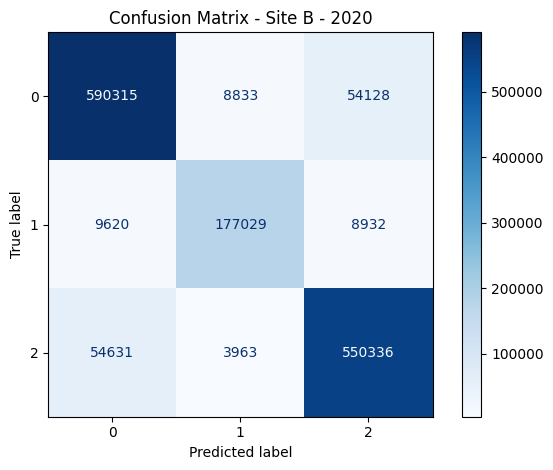


Saved labeled data for bald to true_BCNN_selected_data/true_BCNN_data_bald.npz


In [28]:
for name, query_func in sampling_strategies.items():
    print(f"\n======================")
    print(f" Running strategy: {name.upper()} ")
    print(f"======================")    

    # Re-initializing the model for each strategy
    model = BayesianCNN_FC(in_channels=6, num_classes=3, priors=PRIORS, device=DEVICE).to(DEVICE)
    ckpt = torch.load('/kaggle/input/b_cnn/pytorch/default/1/BCNN.pth', map_location='cpu')

    if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
        state = ckpt['model_state_dict']
    else:
        state = ckpt
    
    new_state = {}
    for k, v in state.items():
        if k.startswith("_orig_mod."):
            new_state[k.replace("_orig_mod.", "")] = v
        else:
            new_state[k] = v
    model.load_state_dict(new_state, strict=True)

    labeled_pool = strategy_pools[name]["labeled"]
    unlabeled_pool = strategy_pools[name]["unlabeled"]
    print('Length of Labeled Pool:', len(labeled_pool))
    print('Length of Unlabeled Pool:', len(unlabeled_pool))

    history = strategy_histories[name]

    # Training on initial labeled samples
    initial_labeled = set(np.random.choice(list(unlabeled_pool), INITIAL_LABELED, replace=False))
    labeled_pool.update(initial_labeled)
    unlabeled_pool.difference_update(initial_labeled)
    print('Length of Labeled Pool:', len(labeled_pool))
    print('Length of Unlabeled Pool:', len(unlabeled_pool))

    train_dataset = Conv1dDataset(X_train[list(labeled_pool)], y_train[list(labeled_pool)])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

     # ===== Class weights =====
    all_labels = []
    for _, y_batch in train_loader:
        all_labels.append(y_batch.numpy())
    
    all_labels = np.concatenate(all_labels)
    classes = np.unique(all_labels)
    class_weights_np = compute_class_weight(class_weight='balanced',
                                            classes=classes, y=all_labels)
    class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(DEVICE)
    class_weights = torch.clamp(class_weights, max=1.25) # Clipping to max 1.00
    print("Class weights:", class_weights)

    #  Train + Evaluate
    print(f'\n-> Training on {INITIAL_LABELED} initially labeled samples ')
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)
    
    train_losses, train_accs = train(model, train_dataset, train_loader, optimizer, class_weights, KL_WEIGHT=KL_WEIGHT, EPOCHS=EPOCHS, T=T)
    loss, acc, kappa, per_class_f1, avg_f1, _ = evaluate(model, val_dataloader, class_weights, T, DEVICE)
    scheduler.step(loss)

    
    print("Per-class F1 scores:", per_class_f1)
    print(f"Validation Accuracy: {acc * 100:.2f}%")
    print(f"Validation Loss: {loss:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    print(f'Kappa: {kappa:.4f}')

    history["rounds"].append(0)
    history["num_labeled"].append(len(labeled_pool))
    history["train_accuracy"].append(train_accs[-1])
    history["train_loss"].append(train_losses[-1])
    history["val_accuracy"].append(acc)
    history["val_loss"].append(loss)
    history["avg_f1"].append(avg_f1)
    history["per_class_f1"].append(per_class_f1.tolist())
    history["kappa"].append(kappa)
    

    for round_num in range(1, AL_ROUNDS + 1):
        print(f"\n--- Round {round_num} [{name}] ---")
        
        # 1. Query k samples
        queried_indices = query_func(
            X=X_train,
            model=model,
            k=QUERY_SIZE,
            device=DEVICE,
            unlabeled_pool=unlabeled_pool,
            T = T
        )
    
        # 2. Update pools
        new_indices = set(queried_indices) - labeled_pool  # avoid duplication
        labeled_pool.update(new_indices)
        unlabeled_pool.difference_update(new_indices)
        print('Length of Labeled Pool:', len(labeled_pool))
        print('Length of Unlabeled Pool:', len(unlabeled_pool))
        
        # 3. Build train loader
        train_dataset = Conv1dDataset(X_train[list(labeled_pool)], y_train[list(labeled_pool)])
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
        # 4. Train + Evaluate
        optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)
    
        train_losses, train_accs = train(model, train_dataset, train_loader, optimizer, class_weights, KL_WEIGHT=KL_WEIGHT, EPOCHS=EPOCHS, T=T)
        loss, acc, kappa, per_class_f1, avg_f1, _ = evaluate(model, val_dataloader, class_weights, T, DEVICE)
        scheduler.step(loss)
        
        print("Per-class F1 scores:", per_class_f1)
        print(f"Validation Accuracy: {acc * 100:.2f}%")
        print(f"Validation Loss: {loss:.4f}")
        print(f"Average F1 Score: {avg_f1:.4f}")
        print(f'Kappa: {kappa:.4f}')
    
        history["rounds"].append(round_num)
        history["num_labeled"].append(len(labeled_pool))
        history["train_accuracy"].append(train_accs[-1])
        history["train_loss"].append(train_losses[-1])
        history["val_accuracy"].append(acc)
        history["val_loss"].append(loss)
        history["avg_f1"].append(avg_f1)
        history["per_class_f1"].append(per_class_f1.tolist())
        history["kappa"].append(kappa)

    
    # Testing the model on test data
    loss, acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, class_weights, T, DEVICE)
    print()
    print("=" * 50)
    print(f'Test Results for Strategy {name.upper()}')
    print("=" * 50)
    print(f"Overall Accuracy: {acc * 100:.2f}%")
    print(f"Loss: {loss:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    print("Per-class F1 scores:", per_class_f1)
    print(f'Kappa: {kappa}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
    plt.tight_layout()
    plt.show()
    print("=" * 50)
    print ()

    # Saving the Labeled Pool for each strategy
    save_dir = "true_BCNN_selected_data"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    
    data_file = os.path.join(save_dir, f"true_BCNN_data_{name}.npz")
    np.savez(
        data_file,
        X=X_train[list(labeled_pool)],
        y=y_train[list(labeled_pool)]
    )
    
    print(f"Saved labeled data for {name} to {data_file}")

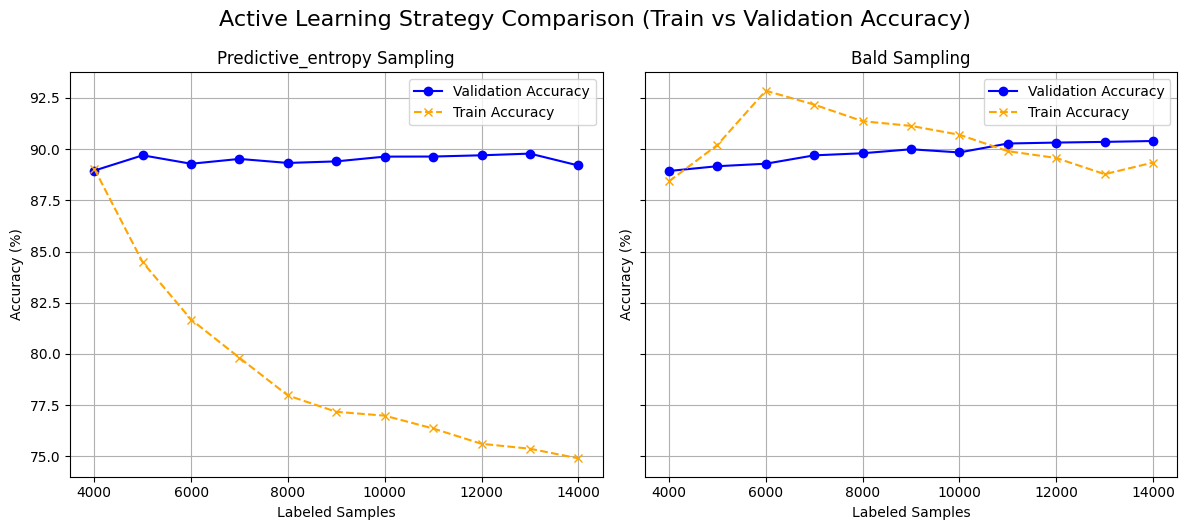

In [29]:
# Accuracy Plot: Train vs Val
n = len(sampling_strategies)  
fig, axs = plt.subplots(1, n, figsize=(6*n, 5), sharey=True)

for i, (name, history) in enumerate(strategy_histories.items()):
    val_accs = [a * 100 for a in history["val_accuracy"]]
    train_accs = [a * 100 for a in history["train_accuracy"]]

    axs[i].plot(history["num_labeled"], val_accs, marker="o", label="Validation Accuracy", color="blue")
    axs[i].plot(history["num_labeled"], train_accs, marker="x", linestyle="--", label="Train Accuracy", color="orange")

    axs[i].set_title(f"{name.capitalize()} Sampling")
    axs[i].set_xlabel("Labeled Samples")
    axs[i].set_ylabel("Accuracy (%)")
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Active Learning Strategy Comparison (Train vs Validation Accuracy)", fontsize=16, y=1.05)
plt.show()

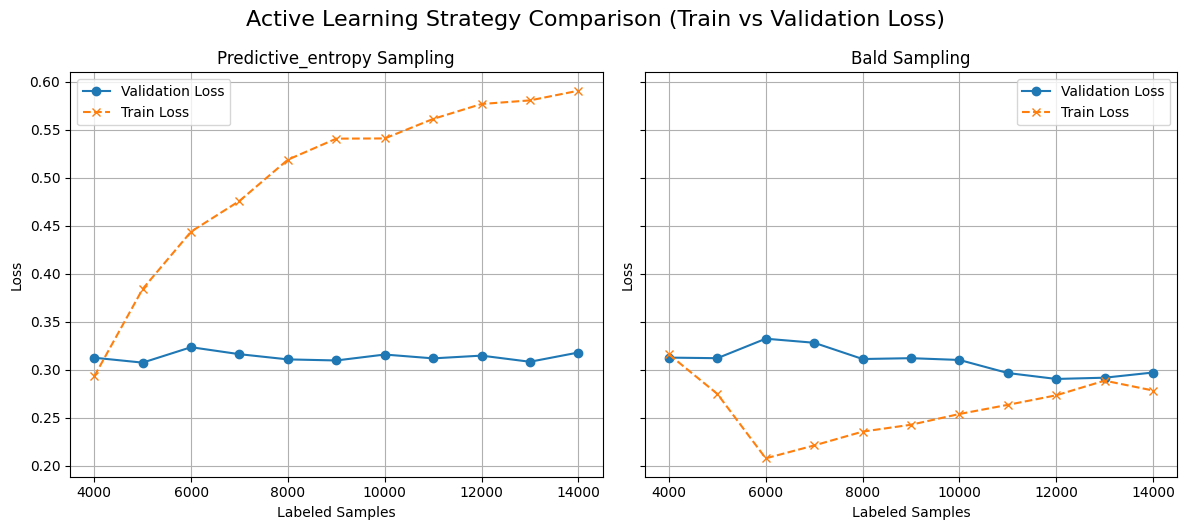

In [ ]:
# Loss Plot: Train vs Val
n = len(sampling_strategies)  
fig, axs = plt.subplots(1, n, figsize=(6*n, 5), sharey=True)

for i, (name, history) in enumerate(strategy_histories.items()):
    val_loss = [l for l in history["val_loss"]]
    train_loss = [l for l in history["train_loss"]]

    axs[i].plot(history["num_labeled"], val_loss, marker="o", label="Validation Loss")
    axs[i].plot(history["num_labeled"], train_loss, marker="x", linestyle="--", label="Train Loss")

    axs[i].set_title(f"{name.capitalize()} Sampling")
    axs[i].set_xlabel("Labeled Samples")
    axs[i].set_ylabel("Loss")
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Active Learning Strategy Comparison (Train vs Validation Loss)", fontsize=16, y=1.05)
plt.show()

## Saving the Results

In [ ]:
# After your active learning loop finishes for all strategies:
output_file = "active_learning_history_trueBCNN.xlsx"

with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
    for strategy_name, history in strategy_histories.items():
        # Convert history dict to DataFrame
        df = pd.DataFrame({
            "round": history["rounds"],
            "num_labeled": history["num_labeled"],
            "train_accuracy": history["train_accuracy"],
            "train_loss": history["train_loss"],
            "val_accuracy": history["val_accuracy"],
            "val_loss": history["val_loss"],
            "avg_f1": history["avg_f1"],
            "kappa": history["kappa"],
            # store per-class f1 as string so Excel can hold it
            "per_class_f1": [",".join(map(str, f1)) for f1 in history["per_class_f1"]]
        })

        # Save each strategy history in its own sheet
        df.to_excel(writer, sheet_name=strategy_name, index=False)

print(f"Saved history of all strategies to {output_file}")

Saved history of all strategies to active_learning_history_trueBCNN.xlsx


In [ ]:
# Zip the folder
shutil.make_archive("true_BCNN_selected_data", 'zip', "true_BCNN_selected_data")

'/kaggle/working/true_BCNN_selected_data.zip'

In [ ]:
FileLink("true_BCNN_selected_data.zip")

/kaggle/working/true_BCNN_selected_data.zip

<hr>